# Classification of key based on chords

The task is to classify each chord segment with a key.

## Inputs  & outputs

Each data point represents a chord segment.

Inputs are chord segments with duration and a set of binary pitch classes contained in the chord. Thus the input dimension is 1+12 = 13.

Output of each data point is the key within the segment represented by its canonical diatonic key root pitch class. So there are 12 possible class values. With one-hot encoding the output dimension is 12.


## Assumptions

- assumptions to simplify the problem:
  - we assume that each segments has just a single chord and key
  - we ignore chord segments with no chord (`N`) or no key (silence)
  - we represent the key with its canonical diatonic key root pitch class
    - ie. no distinction of modes (major, minor, dorian, etc.) or accidentals (sharp, flat)
  - the inputs should be selected such that each input spans a single key, not multiple ones

## The strategy of tasks - from simpler to harder 

First we can try to classify each chord segment independently to establish a baseline performance. In practice this is not too realistic, since the key may be distinguisehd by a set of multiple chords.

Then we can try to use as inputs short sequences of adjacent chord segments of fixed size. This might be more realistic and be usable for non-recurrent ML models.

Ideally we should handle the fact that the sequence of chords is of a variable length and use recurrent models and not be constrained by a fixed window.


## ML algorithms

As for the ML models we should start with a plain multi-class logistic regression.

Then we could try deep neural networks:
- architecture:
  - input layer: 13
  - hidden layer(s): ???
  - output layer: 12
    - soft-max classifer
  - regularization - dropout, ...
- pre-training with an autoencoder, then fine tuning with labels
- experiment with:
  - convolution layers (http://theanets.readthedocs.org/en/stable/reference.html#module-theanets.layers.convolution)
    - eg. we would like to capture several distance metrics on the pitch class space:
      - skip by 1 (plain pitch class neighborhood), skip by 7 (circle-of-fifths similarity)
    - for pitch spaces we could also use skip by 12 (octave similarity)
  - recurrent layers (http://theanets.readthedocs.org/en/stable/reference.html#module-theanets.layers.recurrent)
    - we could use the Predict output layer

## Evaluation

TODO

In [2]:
%pylab inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import glob

pylab.rcParams['figure.figsize'] = (16, 12)

Populating the interactive namespace from numpy and matplotlib


In [11]:
dataset = pd.read_csv('data/beatles/derived/all_chords_with_keys.tsv', sep='\t')
dataset = dataset.dropna()
dataset

,track_id,start,end,duration,label,root,bass,C,Db,D,...,E,F,Gb,G,Ab,A,Bb,B,key_diatonic_root_label,key_diatonic_root
0,0,0.000000,2.612267,2.612267,N,0,0,0,0,0,...,0,0,0,0,0,0,0,0,NaN,NaN
1,0,2.612267,11.459070,8.846803,E,4,4,0,0,0,...,1,0,0,0,1,0,0,1,E,4
2,0,11.459070,12.921927,1.462857,A,9,9,0,1,0,...,1,0,0,0,0,1,0,0,E,4
3,0,12.921927,17.443474,4.521547,E,4,4,0,0,0,...,1,0,0,0,1,0,0,1,E,4
4,0,17.443474,20.410362,2.966888,B,11,11,0,0,0,...,0,0,1,0,0,0,0,1,E,4
5,0,20.410362,21.908049,1.497687,E,4,4,0,0,0,...,1,0,0,0,1,0,0,1,E,4
6,0,21.908049,23.370907,1.462858,E:7/3,4,8,0,0,1,...,1,0,0,0,1,0,0,1,E,4
7,0,23.370907,24.856984,1.486077,A,9,9,0,1,0,...,1,0,0,0,0,1,0,0,E,4
8,0,24.856984,26.343061,1.486077,A:min/b3,9,0,1,0,0,...,1,0,0,0,0,1,0,0,E,4
9,0,26.343061,27.840748,1.497687,E,4,4,0,0,0,...,1,0,0,0,1,0,0,1,E,4


## Simple silly classification of each segment alone

In [4]:
pcs_columns = ['C','Db','D','Eb','E','F','Gb','G','Ab','A','Bb','B']
# note: we could also try use features like 'root' or 'bass'
input_cols = pcs_columns
output_col = 'key_diatonic_root'

def select_X_y(df):
    X = df[input_cols].astype(np.int32)
    y = df[output_col].astype(np.int32)
    return X, y

In [ ]:
X, y = select_X_y(dataset)

In [197]:
len(dataset)

14441

In [198]:
X.head()

,C,Db,D,Eb,E,F,Gb,G,Ab,A,Bb,B
1,0,0,0,0,1,0,0,0,1,0,0,1
2,0,1,0,0,1,0,0,0,0,1,0,0
3,0,0,0,0,1,0,0,0,1,0,0,1
4,0,0,0,1,0,0,1,0,0,0,0,1
5,0,0,0,0,1,0,0,0,1,0,0,1


In [199]:
y.head()

,key_diatonic_root
1,4
2,4
3,4
4,4
5,4


In [24]:
from sklearn.cross_validation import train_test_split

def split_dataset(X, y, test_percentage=0.2, valid_percentage=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_percentage, random_state=random_state)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=valid_percentage/(1-test_percentage), random_state=random_state)
    return (X_train, y_train), (X_valid, y_valid), (X_test, y_test)

In [ ]:
((X_train, y_train), (X_valid, y_valid), (X_test, y_test)) = split_dataset(X, y)

[d.shape for d in (X_train, y_train, X_valid, y_valid, X_test, y_test)]

In [27]:
from sklearn.linear_model import LogisticRegression

In [202]:
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001)

In [31]:
from sklearn.metrics import classification_report, confusion_matrix

def accuracy_report(model, X_train, y_train, X_valid, y_valid):
    # mean accuracy on the given test data and labels
    accuracy_train, accuracy_valid = model.score(X_train, y_train), model.score(X_valid, y_valid)
    print('training set accuracy (%):', accuracy_train)
    print('validation set accuracy (%):', accuracy_valid)
    print('difference (% points):', accuracy_train - accuracy_valid)

In [ ]:
accuracy_report(lr_model, X_train, y_train, X_valid, y_valid)

In [271]:
# TODO: we could better use http://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html

In [208]:
random_batches = 100
y_random_uniform = np.random.random_integers(low=0, high=11, size=(len(X_valid), random_batches))
y_pred_lr_valid = lr_model.predict(X_valid)

In [209]:
def prior_class_probabilities(y):
    priors = pd.Series(np.zeros(12))
    hist = (pd.Series(y.ravel()).value_counts() / len(y))
    priors[hist.index] = hist
    return priors

priors_valid = prior_class_probabilities(y_valid)
priors_valid

0     0.153393
1     0.005194
2     0.135042
3     0.029778
4     0.145776
5     0.066136
6     0.016620
7     0.200485
8     0.013850
9     0.176939
10    0.016620
11    0.040166
dtype: float64

In [211]:
# random samples of classes based on prior probabilities of each class
y_random_prior = numpy.random.choice(np.arange(12), size=(len(y_valid), random_batches), p=priors_valid)
pd.Series(y_random_prior[0]).value_counts() / len(y_random_prior)

0    0.008310
7    0.006925
2    0.005194
9    0.004155
4    0.003463
5    0.002770
3    0.002770
8    0.000693
1    0.000346
dtype: float64

In [218]:
mean_random_uniform_accuracy = ((y_random_uniform == np.outer(np.ones(y_random_uniform.shape[1]), y_valid).T).sum(axis=0) / len(X_valid)).mean() * 100
print('validation set, mean accuracy of uniform random guess (%):', mean_random_uniform_accuracy)
mean_random_prior_accuracy = ((y_random_prior == np.outer(np.ones(y_random_prior.shape[1]), y_valid).T).sum(axis=0) / len(X_valid)).mean() * 100
print('validation set, mean accuracy of random guess with prior class probabilities (%):', mean_random_prior_accuracy)

lr_accuracy = sum(y_pred_lr_valid == y_valid.ravel()) / len(X_valid) * 100
print('validation set, accuracy of LR model (%):', lr_accuracy)

print('the model is better than uniform random guess', lr_accuracy / mean_random_uniform_accuracy, 'times')
print('the model is better than prior random guess', lr_accuracy / mean_random_prior_accuracy, 'times')

validation set, mean accuracy of uniform random guess (%): 8.36842105263
validation set, mean accuracy of random guess with prior class probabilities (%): 14.1371191136
validation set, accuracy of LR model (%): 42.3476454294
the model is better than uniform random guess 5.06041046011 times
the model is better than prior random guess 2.99549328892 times


We can see that the seemingly good performance of the simple model is caused by the model trained on the skewed class prior probabilities. When we compare the model to random guessing based on the priors, the model is just 3x better than this kind of random guessing.

In [219]:
print(classification_report(y_pred_lr_valid, y_valid))

             precision    recall  f1-score   support

          0       0.57      0.47      0.52       535
          1       0.00      0.00      0.00         0
          2       0.37      0.34      0.36       427
          3       0.45      0.34      0.39       114
          4       0.55      0.47      0.50       491
          5       0.29      0.42      0.34       130
          6       0.44      0.39      0.41        54
          7       0.42      0.46      0.44       532
          8       0.25      0.26      0.25        39
          9       0.41      0.41      0.41       507
         10       0.25      0.29      0.27        41
         11       0.03      0.22      0.06        18

avg / total       0.45      0.42      0.43      2888



/Users/bzamecnik/Documents/dev/pyvenv/py3.4/lib/python3.4/site-packages/sklearn/metrics/metrics.py:1773: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### Notes

- an accuracy of pure guess should be theoretically 1/12 ~= 8.333 %, a few rounds of random samples give a very close number
- even with this simple ML method and context of a single chord the accuracy both both sets is not to bad (~ 5x better than random guess)
- the training accuracy is just slightly better than the validation one
  - it means the model is very biased and is not overfitted, more data would likely not help
- the classes are very skewed, so we could generate synthetic data points in order to make classes uniform

Let's look at the actual results of classification on the validation set.

In [56]:
def classification_results(X, y_true, y_pred):
    return pd.DataFrame(
        np.hstack([X, y_true.reshape(-1, 1), y_pred.reshape(-1, 1)]),
        columns=input_cols+['label_true']+['label_pred'])

In [39]:
classification_valid = classification_results(X_valid, y_valid, y_pred_lr_valid)

classification_valid['is_correct'] = classification_valid['label_true'] == classification_valid['label_pred']

print('accuracy on validation set (%)', sum(classification_valid['is_correct']) / len(classification_valid) * 100)

accuracy on validation set (%) 42.3476454294


The `score()` from the `LogisticRegression` model seems to really corresponds to manually computed accuracy.

In [59]:
def key_classification_error_report(y_true, y_pred):
    errors = pd.Series(((y_true - y_pred) + 12) % 12)
    errors_hist = errors.value_counts()
    stem(errors_hist / len(errors) * 100)
    gca().set_xticks(np.arange(len(errors_hist)))
    gca().set_xticklabels(errors_hist.index)
    xlabel('error (true - predicted key pitch class)')
    ylabel('%')
    return errors, errors_hist

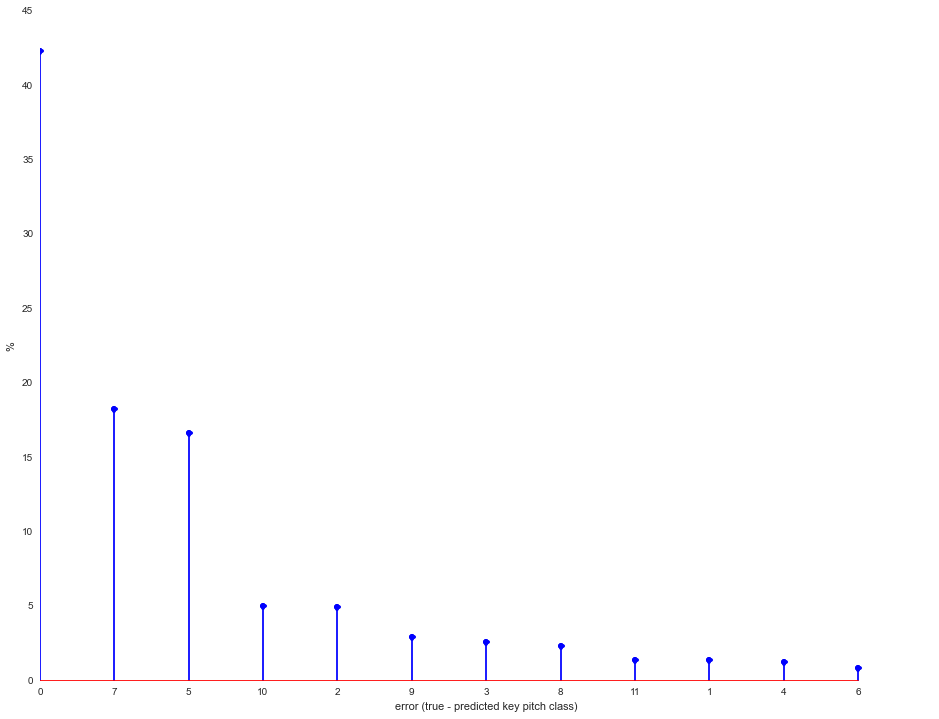

In [264]:
key_classification_error_report(classification['label_true'], classification['label_pred']);

### Synthetic data - all transpositions of the original dataset

This dataset show have all classes with uniform prior probabilities.

It is expected that the model would perform worse since it cannot overfit on the priors.

In [248]:
dataset_synth = pd.read_csv('data/beatles/derived/all_chords_with_keys_synth.tsv', sep='\t')

In [249]:
dataset_synth = dataset_synth.dropna()
X, y = select_X_y(dataset_synth)

In [250]:
len(dataset_synth), len(X), len(y)

(173292, 173292, 173292)

In [251]:
((X_train, y_train), (X_valid, y_valid), (X_test, y_test)) = split_dataset(X, y)

In [253]:
lr_model_synth = LogisticRegression()
lr_model_synth.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001)

In [254]:
accuracy_report(lr_model_synth, X_train, y_train, X_valid, y_valid)
lr_synth_accuracy = 100 * lr_model_synth.score(X_valid, y_valid)
print('accuracy of model without synth data', lr_accuracy)
print('the model is better than uniform random guess', lr_synth_accuracy / mean_random_uniform_accuracy, 'times')

training set accuracy (%): 0.381585781061
validation set accuracy (%): 0.379122305895
difference (% points): 0.00246347516608
accuracy of model withou synth data 42.3476454294
the model is better than uniform random guess 4.53039233459 times


We can se the model is worse than model trained on data with skewed classes but not dramatically.

In [266]:
y_pred_lr_synth_valid = lr_model_synth.predict(X_valid)

(34659, 12) (34659,) (34659,)


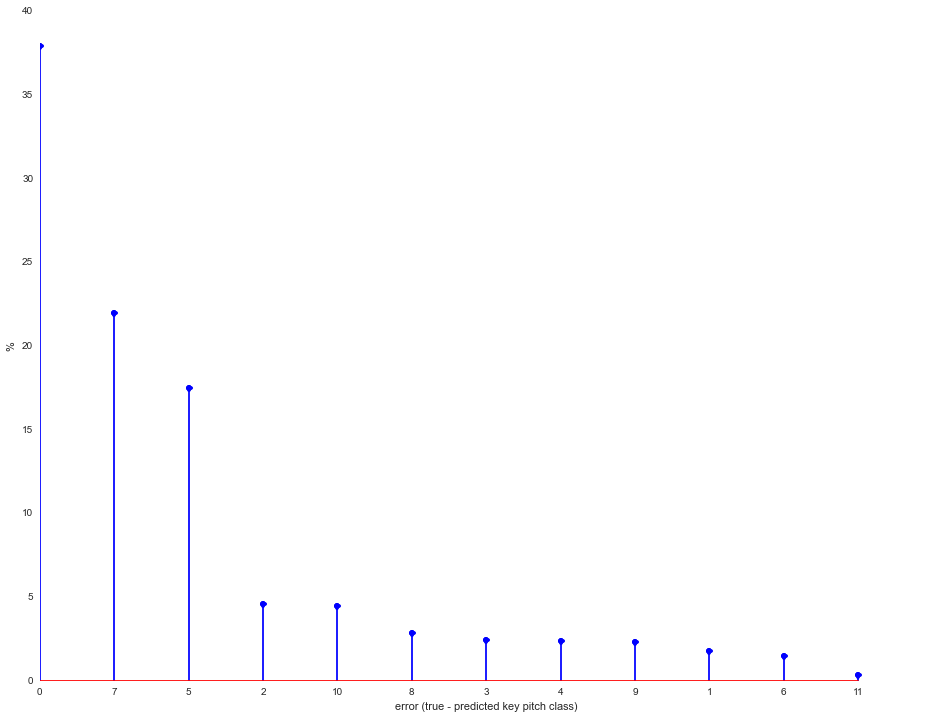

In [267]:
key_classification_error_report(classification_results(X_valid, y_valid, y_pred_lr_synth_valid));

Since there's almost no gap between training and validation accuracy the model seems to be highly biased, just too simple. We can try a few combinations of regularization parameters, but we expect regularization do not help here.

As for the kind of errors, we can see the correct key is often quite close to the true key on the circle of fifths. Moreover, the distribution of errors nicely follows the two-way distance on the circle of fifths. This is an important thing and should be taken into account when choosing/designing the cost function or validation metric.

In [259]:
from sklearn.grid_search import GridSearchCV

def tune_lr_model_on_grid():
    model = LogisticRegression()
    grid = GridSearchCV(estimator=model, param_grid=dict(C=[0.1, 0.5, 1], penalty=['l2', 'l1']))
    # let the CV do multiple train-valid splits
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    grid.fit(X_train, y_train)
    return grid

lr_model_synth_grid = tune_lr_model_on_grid()
print(lr_model_synth_grid)
print('best mean accuracy:', lr_model_synth_grid.best_score_)
print(lr_model_synth_grid.best_estimator_.C, lr_model_synth_grid.best_estimator_.penalty)
print(lr_model_synth_grid.grid_scores_)

GridSearchCV(cv=None,
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'C': [0.1, 0.5, 1], 'penalty': ['l2', 'l1']},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=0)
0.380508248397
1
GridSearchCV(cv=None,
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'C': [0.1, 0.5, 1], 'penalty': ['l2', 'l1']},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=0)
best mean accuracy: 0.380508248397
1 l2
[mean: 0.38034, std: 0.00161, params: {'C': 0.1, 'penalty': 'l2'}, mean: 0.38041, std: 0.00153, params: {'C': 0.1, 'penalty':

As we can see regularization didn't help.

### Linear model trained with stochastic gradient descent

iter: 0 validation score: 0.3545110938
iter: 1 validation score: 0.362532098445
iter: 2 validation score: 0.373409504025
iter: 3 validation score: 0.378545255201
iter: 4 validation score: 0.378689517874
iter: 5 validation score: 0.378660665339
iter: 6 validation score: 0.378776075478
iter: 7 validation score: 0.378804928013
iter: 8 validation score: 0.378776075478
iter: 9 validation score: 0.378458697597
iter: 10 validation score: 0.378458697597
iter: 11 validation score: 0.378718370409
iter: 12 validation score: 0.378660665339
iter: 13 validation score: 0.378718370409
iter: 14 validation score: 0.378718370409


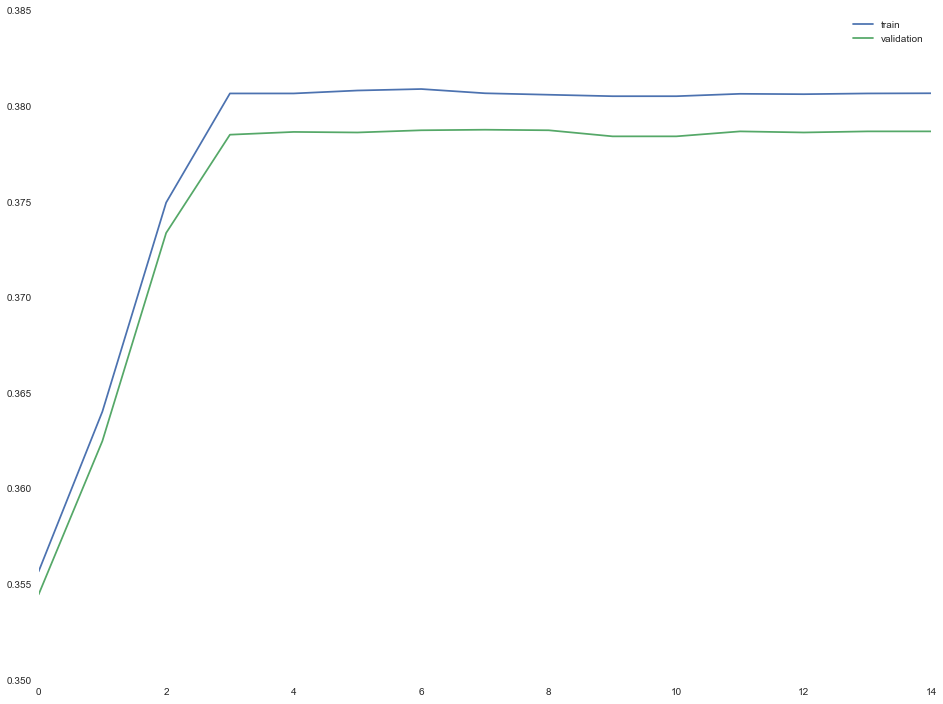

In [290]:
from sklearn.linear_model import SGDClassifier
lsgd_model_synth = SGDClassifier(loss='log')
lsgd_scores = {'train':[], 'valid':[]}
for i in range(15):
    lsgd_model_synth.partial_fit(X_train, y_train, classes=np.arange(12))
    lsgd_scores['train'].append(lsgd_model_synth.score(X_train, y_train))
    lsgd_scores['valid'].append(lsgd_model_synth.score(X_valid, y_valid))
    print('iter:', i, 'validation score:', lsgd_scores['valid'][-1])
plot(lsgd_scores['train'], label='train')
plot(lsgd_scores['valid'], label='validation')
legend();

It seems that the logistic regression trained with SGD (full-batch) obtains a very similar result.

### Decision tree

In [293]:
from sklearn.tree import DecisionTreeClassifier
tree_model = DecisionTreeClassifier()
tree_model = tree_model.fit(X_train, y_train)
print('training score', tree_model.score(X_train, y_train))
print('validation score', tree_model.score(X_valid, y_valid))

training score 0.39647411853
validation score 0.392221356646


Also a simple decision tree gives a similar result.

## Sequence of multiple chords as an input feature

As we could see trying to classify the key based on a single chord gives not completely bad results, it is very limited. Naturally even humans perceive the key in a context of multiple chords. So we should now move to providing input features that consist of a sequence of multiple chords. We expect much better results.

In order to keep things simple we restrict our problem such that each sequence of adjacent chords lies within a single key, ie. no sequence spans multiple keys. We then classify the key for for the whole sequence.

A question is how the context size affects the accuracy. What is a good tradeoff between accuracy and redundancy?

# Next steps

- prepare chord blocks
  - put several adjacent chords within a single key into each data point
  - chord block are expected to carry enough information to enable more reasonable key classification
  - use the synthetic unskewed data
- try the same model training on the chord block data
  - LogisticRegression [with cross-validated grid search]
  - try some tree-based model - eg. RandomForestClassifier
  - try deep neural networks
- explore the effect of context size
- try RNNs without the need on the full sequences (no need for explicit windowing)

In [72]:
dataset = pd.read_csv('data/beatles/derived/all_chords_with_keys_synth_rolling_16.tsv', sep='\t')
X, y = dataset.iloc[:,:-1].astype(int32), dataset.iloc[:,-1].astype(int32)
((X_train, y_train), (X_valid, y_valid), (X_test, y_test)) = split_dataset(X, y)

[d.shape for d in (X_train, y_train, X_valid, y_valid, X_test, y_test)]

[(103965, 192), (103965,), (34656, 192), (34656,), (34656, 192), (34656,)]

In [39]:
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001)

In [52]:
lr_model.score(X_train, y_train), lr_model.score(X_valid, y_valid)

(0.72085798105131538, 0.71592220683287167)

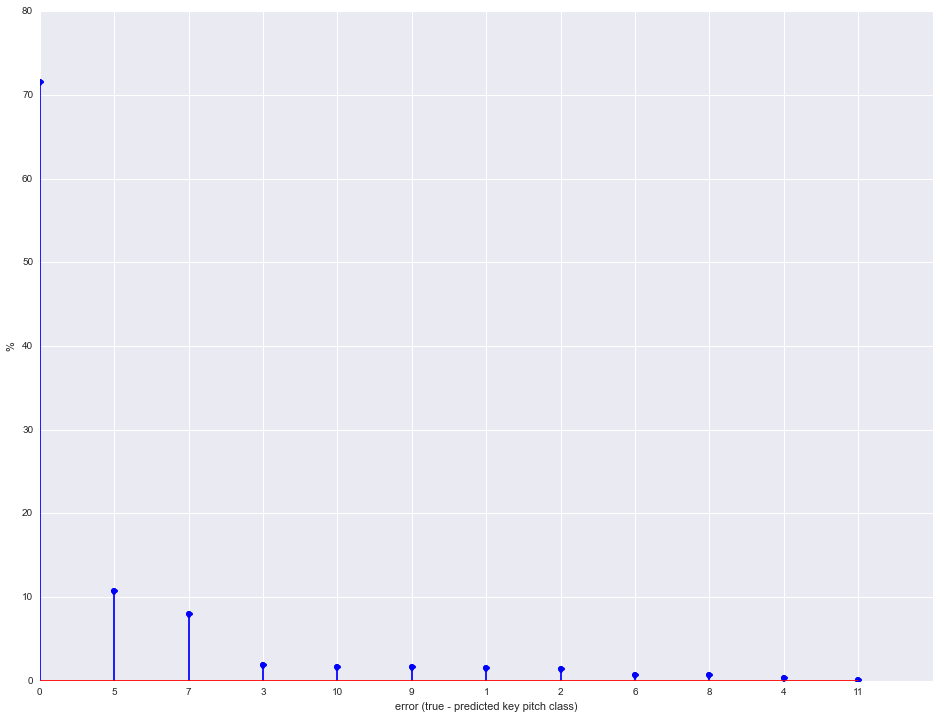

In [60]:
key_classification_error_report(y_valid, lr_model.predict(X_valid));

By adding context we can get significant improvemnt in classification performance, eg. from 38% to 71% (!) even with a simple logistic regression model.

# Neural networks

In [88]:
import theanets
from sklearn.metrics import accuracy_score

In [95]:
def theano_accuracy_report(model):
    y_train_pred = model.predict(X_train.astype(float32))
    y_valid_pred = model.predict(X_valid.astype(float32))
    print('training score:', accuracy_score(y_train, y_train_pred))
    print('validation score:', accuracy_score(y_valid, y_valid_pred))
    key_classification_error_report(y_valid, y_valid_pred)

In [75]:
# no hidden layers, no pretraining or regularization
exp = theanets.Experiment(theanets.Classifier, layers=[X.shape[1], 12])
exp.train(
    (X_train.astype(float32),y_train),
    (X_valid.astype(float32),y_valid),
    algo='sgd', learning_rate=1e-4, momentum=0.9)

INFO:theanets.layers.feedforward:layer Input "in": 192 inputs


I 2015-09-22 09:28:03 theanets.layers.feedforward:41 layer Input "in": 192 inputs


INFO:theanets.layers.base:layer Feedforward "out": (in:out)192 -> 12, softmax, 2316 parameters


I 2015-09-22 09:28:03 theanets.layers.base:316 layer Feedforward "out": (in:out)192 -> 12, softmax, 2316 parameters


INFO:theanets.graph:network has 2316 total parameters


I 2015-09-22 09:28:03 theanets.graph:114 network has 2316 total parameters


INFO:downhill.dataset:valid: 1083 of 1083 mini-batches of (32, 192); (32,)


I 2015-09-22 09:28:03 downhill.dataset:144 valid: 1083 of 1083 mini-batches of (32, 192); (32,)


INFO:downhill.dataset:train: 3249 of 3249 mini-batches of (32, 192); (32,)


I 2015-09-22 09:28:03 downhill.dataset:144 train: 3249 of 3249 mini-batches of (32, 192); (32,)


INFO:downhill.base:-- patience = 5


I 2015-09-22 09:28:03 downhill.base:378 -- patience = 5


INFO:downhill.base:-- validate_every = 10


I 2015-09-22 09:28:03 downhill.base:379 -- validate_every = 10


INFO:downhill.base:-- min_improvement = 0


I 2015-09-22 09:28:03 downhill.base:380 -- min_improvement = 0


INFO:downhill.base:-- max_gradient_norm = 0


I 2015-09-22 09:28:03 downhill.base:381 -- max_gradient_norm = 0


INFO:downhill.base:-- max_gradient_elem = 0


I 2015-09-22 09:28:03 downhill.base:382 -- max_gradient_elem = 0


INFO:downhill.base:-- learning_rate = 0.0001


I 2015-09-22 09:28:03 downhill.base:383 -- learning_rate = 0.0001


INFO:downhill.base:-- momentum = 0.9


I 2015-09-22 09:28:03 downhill.base:384 -- momentum = 0.9


INFO:downhill.base:-- nesterov = False


I 2015-09-22 09:28:03 downhill.base:385 -- nesterov = False


INFO:downhill.adaptive:-- rms_halflife = 14


I 2015-09-22 09:28:03 downhill.adaptive:220 -- rms_halflife = 14


INFO:downhill.adaptive:-- rms_regularizer = 1e-08


I 2015-09-22 09:28:03 downhill.adaptive:221 -- rms_regularizer = 1e-08


INFO:downhill.base:compiling evaluation function


I 2015-09-22 09:28:03 downhill.base:112 compiling evaluation function


INFO:downhill.base:compiling RMSProp function


I 2015-09-22 09:28:04 downhill.base:118 compiling RMSProp function


INFO:downhill.base:validation 0 loss=2.867817 err=2.867817 acc=0.081198 *


I 2015-09-22 09:28:04 downhill.base:226 validation 0 loss=2.867817 err=2.867817 acc=0.081198 *


INFO:downhill.base:RMSProp 1 loss=1.057072 err=1.057072 acc=0.711126


I 2015-09-22 09:28:05 downhill.base:226 RMSProp 1 loss=1.057072 err=1.057072 acc=0.711126


INFO:downhill.base:RMSProp 2 loss=0.991709 err=0.991709 acc=0.730833


I 2015-09-22 09:28:07 downhill.base:226 RMSProp 2 loss=0.991709 err=0.991709 acc=0.730833


INFO:downhill.base:RMSProp 3 loss=0.986957 err=0.986957 acc=0.729553


I 2015-09-22 09:28:08 downhill.base:226 RMSProp 3 loss=0.986957 err=0.986957 acc=0.729553


INFO:downhill.base:RMSProp 4 loss=0.986034 err=0.986034 acc=0.728889


I 2015-09-22 09:28:09 downhill.base:226 RMSProp 4 loss=0.986034 err=0.986034 acc=0.728889


INFO:downhill.base:RMSProp 5 loss=0.985372 err=0.985372 acc=0.727331


I 2015-09-22 09:28:10 downhill.base:226 RMSProp 5 loss=0.985372 err=0.985372 acc=0.727331


INFO:downhill.base:RMSProp 6 loss=0.984743 err=0.984743 acc=0.728273


I 2015-09-22 09:28:11 downhill.base:226 RMSProp 6 loss=0.984743 err=0.984743 acc=0.728273


INFO:downhill.base:RMSProp 7 loss=0.984713 err=0.984713 acc=0.727485


I 2015-09-22 09:28:12 downhill.base:226 RMSProp 7 loss=0.984713 err=0.984713 acc=0.727485


INFO:downhill.base:RMSProp 8 loss=0.984948 err=0.984948 acc=0.728495


I 2015-09-22 09:28:13 downhill.base:226 RMSProp 8 loss=0.984948 err=0.984948 acc=0.728495


INFO:downhill.base:RMSProp 9 loss=0.984349 err=0.984349 acc=0.728129


I 2015-09-22 09:28:14 downhill.base:226 RMSProp 9 loss=0.984349 err=0.984349 acc=0.728129


INFO:downhill.base:RMSProp 10 loss=0.983927 err=0.983927 acc=0.727033


I 2015-09-22 09:28:15 downhill.base:226 RMSProp 10 loss=0.983927 err=0.983927 acc=0.727033


INFO:downhill.base:validation 1 loss=0.989149 err=0.989149 acc=0.729196 *


I 2015-09-22 09:28:15 downhill.base:226 validation 1 loss=0.989149 err=0.989149 acc=0.729196 *


INFO:downhill.base:RMSProp 11 loss=0.984644 err=0.984644 acc=0.728513


I 2015-09-22 09:28:16 downhill.base:226 RMSProp 11 loss=0.984644 err=0.984644 acc=0.728513


INFO:downhill.base:RMSProp 12 loss=0.984121 err=0.984121 acc=0.726965


I 2015-09-22 09:28:17 downhill.base:226 RMSProp 12 loss=0.984121 err=0.984121 acc=0.726965


INFO:downhill.base:RMSProp 13 loss=0.984243 err=0.984243 acc=0.727400


I 2015-09-22 09:28:18 downhill.base:226 RMSProp 13 loss=0.984243 err=0.984243 acc=0.727400


INFO:downhill.base:RMSProp 14 loss=0.984540 err=0.984540 acc=0.727946


I 2015-09-22 09:28:19 downhill.base:226 RMSProp 14 loss=0.984540 err=0.984540 acc=0.727946


INFO:downhill.base:RMSProp 15 loss=0.983947 err=0.983947 acc=0.726946


I 2015-09-22 09:28:20 downhill.base:226 RMSProp 15 loss=0.983947 err=0.983947 acc=0.726946


INFO:downhill.base:RMSProp 16 loss=0.984514 err=0.984514 acc=0.726187


I 2015-09-22 09:28:21 downhill.base:226 RMSProp 16 loss=0.984514 err=0.984514 acc=0.726187


INFO:downhill.base:RMSProp 17 loss=0.984085 err=0.984085 acc=0.727303


I 2015-09-22 09:28:22 downhill.base:226 RMSProp 17 loss=0.984085 err=0.984085 acc=0.727303


INFO:downhill.base:RMSProp 18 loss=0.984627 err=0.984627 acc=0.726330


I 2015-09-22 09:28:23 downhill.base:226 RMSProp 18 loss=0.984627 err=0.984627 acc=0.726330


INFO:downhill.base:RMSProp 19 loss=0.983704 err=0.983704 acc=0.727148


I 2015-09-22 09:28:24 downhill.base:226 RMSProp 19 loss=0.983704 err=0.983704 acc=0.727148


INFO:downhill.base:RMSProp 20 loss=0.984233 err=0.984233 acc=0.727881


I 2015-09-22 09:28:25 downhill.base:226 RMSProp 20 loss=0.984233 err=0.984233 acc=0.727881


INFO:downhill.base:validation 2 loss=0.987955 err=0.987955 acc=0.727089 *


I 2015-09-22 09:28:25 downhill.base:226 validation 2 loss=0.987955 err=0.987955 acc=0.727089 *


INFO:downhill.base:RMSProp 21 loss=0.984349 err=0.984349 acc=0.727495


I 2015-09-22 09:28:26 downhill.base:226 RMSProp 21 loss=0.984349 err=0.984349 acc=0.727495


INFO:downhill.base:RMSProp 22 loss=0.983837 err=0.983837 acc=0.726870


I 2015-09-22 09:28:27 downhill.base:226 RMSProp 22 loss=0.983837 err=0.983837 acc=0.726870


INFO:downhill.base:RMSProp 23 loss=0.983572 err=0.983572 acc=0.727400


I 2015-09-22 09:28:28 downhill.base:226 RMSProp 23 loss=0.983572 err=0.983572 acc=0.727400


INFO:downhill.base:RMSProp 24 loss=0.984239 err=0.984239 acc=0.726736


I 2015-09-22 09:28:29 downhill.base:226 RMSProp 24 loss=0.984239 err=0.984239 acc=0.726736


INFO:downhill.base:RMSProp 25 loss=0.984282 err=0.984282 acc=0.727224


I 2015-09-22 09:28:30 downhill.base:226 RMSProp 25 loss=0.984282 err=0.984282 acc=0.727224


INFO:downhill.base:RMSProp 26 loss=0.984110 err=0.984110 acc=0.727670


I 2015-09-22 09:28:30 downhill.base:226 RMSProp 26 loss=0.984110 err=0.984110 acc=0.727670


INFO:downhill.base:RMSProp 27 loss=0.984089 err=0.984089 acc=0.728032


I 2015-09-22 09:28:31 downhill.base:226 RMSProp 27 loss=0.984089 err=0.984089 acc=0.728032


INFO:downhill.base:RMSProp 28 loss=0.984372 err=0.984372 acc=0.727706


I 2015-09-22 09:28:32 downhill.base:226 RMSProp 28 loss=0.984372 err=0.984372 acc=0.727706


INFO:downhill.base:RMSProp 29 loss=0.984408 err=0.984408 acc=0.727004


I 2015-09-22 09:28:33 downhill.base:226 RMSProp 29 loss=0.984408 err=0.984408 acc=0.727004


INFO:downhill.base:RMSProp 30 loss=0.984162 err=0.984162 acc=0.727119


I 2015-09-22 09:28:35 downhill.base:226 RMSProp 30 loss=0.984162 err=0.984162 acc=0.727119


INFO:downhill.base:validation 3 loss=0.990214 err=0.990214 acc=0.727407


I 2015-09-22 09:28:35 downhill.base:226 validation 3 loss=0.990214 err=0.990214 acc=0.727407


INFO:downhill.base:RMSProp 31 loss=0.984148 err=0.984148 acc=0.727860


I 2015-09-22 09:28:36 downhill.base:226 RMSProp 31 loss=0.984148 err=0.984148 acc=0.727860


INFO:downhill.base:RMSProp 32 loss=0.984465 err=0.984465 acc=0.726908


I 2015-09-22 09:28:37 downhill.base:226 RMSProp 32 loss=0.984465 err=0.984465 acc=0.726908


INFO:downhill.base:RMSProp 33 loss=0.983813 err=0.983813 acc=0.727186


I 2015-09-22 09:28:38 downhill.base:226 RMSProp 33 loss=0.983813 err=0.983813 acc=0.727186


INFO:downhill.base:RMSProp 34 loss=0.984134 err=0.984134 acc=0.727350


I 2015-09-22 09:28:39 downhill.base:226 RMSProp 34 loss=0.984134 err=0.984134 acc=0.727350


INFO:downhill.base:RMSProp 35 loss=0.983718 err=0.983718 acc=0.727022


I 2015-09-22 09:28:40 downhill.base:226 RMSProp 35 loss=0.983718 err=0.983718 acc=0.727022


INFO:downhill.base:RMSProp 36 loss=0.984266 err=0.984266 acc=0.727023


I 2015-09-22 09:28:41 downhill.base:226 RMSProp 36 loss=0.984266 err=0.984266 acc=0.727023


INFO:downhill.base:RMSProp 37 loss=0.984069 err=0.984069 acc=0.727323


I 2015-09-22 09:28:42 downhill.base:226 RMSProp 37 loss=0.984069 err=0.984069 acc=0.727323


INFO:downhill.base:RMSProp 38 loss=0.983773 err=0.983773 acc=0.726176


I 2015-09-22 09:28:43 downhill.base:226 RMSProp 38 loss=0.983773 err=0.983773 acc=0.726176


INFO:downhill.base:RMSProp 39 loss=0.984460 err=0.984460 acc=0.727581


I 2015-09-22 09:28:44 downhill.base:226 RMSProp 39 loss=0.984460 err=0.984460 acc=0.727581


INFO:downhill.base:RMSProp 40 loss=0.984202 err=0.984202 acc=0.727350


I 2015-09-22 09:28:45 downhill.base:226 RMSProp 40 loss=0.984202 err=0.984202 acc=0.727350


INFO:downhill.base:validation 4 loss=0.989547 err=0.989547 acc=0.728763


I 2015-09-22 09:28:45 downhill.base:226 validation 4 loss=0.989547 err=0.989547 acc=0.728763


INFO:downhill.base:RMSProp 41 loss=0.984240 err=0.984240 acc=0.726321


I 2015-09-22 09:28:46 downhill.base:226 RMSProp 41 loss=0.984240 err=0.984240 acc=0.726321


INFO:downhill.base:RMSProp 42 loss=0.984125 err=0.984125 acc=0.727294


I 2015-09-22 09:28:47 downhill.base:226 RMSProp 42 loss=0.984125 err=0.984125 acc=0.727294


INFO:downhill.base:RMSProp 43 loss=0.983844 err=0.983844 acc=0.726966


I 2015-09-22 09:28:48 downhill.base:226 RMSProp 43 loss=0.983844 err=0.983844 acc=0.726966


INFO:downhill.base:RMSProp 44 loss=0.983985 err=0.983985 acc=0.726813


I 2015-09-22 09:28:49 downhill.base:226 RMSProp 44 loss=0.983985 err=0.983985 acc=0.726813


INFO:downhill.base:RMSProp 45 loss=0.984097 err=0.984097 acc=0.727793


I 2015-09-22 09:28:50 downhill.base:226 RMSProp 45 loss=0.984097 err=0.984097 acc=0.727793


INFO:downhill.base:RMSProp 46 loss=0.984294 err=0.984294 acc=0.727485


I 2015-09-22 09:28:51 downhill.base:226 RMSProp 46 loss=0.984294 err=0.984294 acc=0.727485


INFO:downhill.base:RMSProp 47 loss=0.984080 err=0.984080 acc=0.727658


I 2015-09-22 09:28:52 downhill.base:226 RMSProp 47 loss=0.984080 err=0.984080 acc=0.727658


INFO:downhill.base:RMSProp 48 loss=0.983487 err=0.983487 acc=0.726695


I 2015-09-22 09:28:53 downhill.base:226 RMSProp 48 loss=0.983487 err=0.983487 acc=0.726695


INFO:downhill.base:RMSProp 49 loss=0.984433 err=0.984433 acc=0.727074


I 2015-09-22 09:28:54 downhill.base:226 RMSProp 49 loss=0.984433 err=0.984433 acc=0.727074


INFO:downhill.base:RMSProp 50 loss=0.984034 err=0.984034 acc=0.726773


I 2015-09-22 09:28:55 downhill.base:226 RMSProp 50 loss=0.984034 err=0.984034 acc=0.726773


INFO:downhill.base:validation 5 loss=0.987948 err=0.987948 acc=0.728416 *


I 2015-09-22 09:28:55 downhill.base:226 validation 5 loss=0.987948 err=0.987948 acc=0.728416 *


INFO:downhill.base:RMSProp 51 loss=0.984345 err=0.984345 acc=0.727246


I 2015-09-22 09:28:56 downhill.base:226 RMSProp 51 loss=0.984345 err=0.984345 acc=0.727246


INFO:downhill.base:RMSProp 52 loss=0.984430 err=0.984430 acc=0.726429


I 2015-09-22 09:28:56 downhill.base:226 RMSProp 52 loss=0.984430 err=0.984430 acc=0.726429


INFO:downhill.base:RMSProp 53 loss=0.984107 err=0.984107 acc=0.727929


I 2015-09-22 09:28:57 downhill.base:226 RMSProp 53 loss=0.984107 err=0.984107 acc=0.727929


INFO:downhill.base:RMSProp 54 loss=0.983981 err=0.983981 acc=0.728052


I 2015-09-22 09:28:58 downhill.base:226 RMSProp 54 loss=0.983981 err=0.983981 acc=0.728052


INFO:downhill.base:RMSProp 55 loss=0.983950 err=0.983950 acc=0.727475


I 2015-09-22 09:29:00 downhill.base:226 RMSProp 55 loss=0.983950 err=0.983950 acc=0.727475


INFO:downhill.base:RMSProp 56 loss=0.984073 err=0.984073 acc=0.727514


I 2015-09-22 09:29:01 downhill.base:226 RMSProp 56 loss=0.984073 err=0.984073 acc=0.727514


INFO:downhill.base:RMSProp 57 loss=0.984372 err=0.984372 acc=0.727063


I 2015-09-22 09:29:02 downhill.base:226 RMSProp 57 loss=0.984372 err=0.984372 acc=0.727063


INFO:downhill.base:RMSProp 58 loss=0.984092 err=0.984092 acc=0.727456


I 2015-09-22 09:29:03 downhill.base:226 RMSProp 58 loss=0.984092 err=0.984092 acc=0.727456


INFO:downhill.base:RMSProp 59 loss=0.983836 err=0.983836 acc=0.727659


I 2015-09-22 09:29:04 downhill.base:226 RMSProp 59 loss=0.983836 err=0.983836 acc=0.727659


INFO:downhill.base:RMSProp 60 loss=0.983987 err=0.983987 acc=0.728023


I 2015-09-22 09:29:05 downhill.base:226 RMSProp 60 loss=0.983987 err=0.983987 acc=0.728023


INFO:downhill.base:validation 6 loss=0.995586 err=0.995586 acc=0.726801


I 2015-09-22 09:29:05 downhill.base:226 validation 6 loss=0.995586 err=0.995586 acc=0.726801


INFO:downhill.base:RMSProp 61 loss=0.983978 err=0.983978 acc=0.726753


I 2015-09-22 09:29:06 downhill.base:226 RMSProp 61 loss=0.983978 err=0.983978 acc=0.726753


INFO:downhill.base:RMSProp 62 loss=0.984062 err=0.984062 acc=0.727188


I 2015-09-22 09:29:07 downhill.base:226 RMSProp 62 loss=0.984062 err=0.984062 acc=0.727188


INFO:downhill.base:RMSProp 63 loss=0.984010 err=0.984010 acc=0.727160


I 2015-09-22 09:29:08 downhill.base:226 RMSProp 63 loss=0.984010 err=0.984010 acc=0.727160


INFO:downhill.base:RMSProp 64 loss=0.983626 err=0.983626 acc=0.727467


I 2015-09-22 09:29:08 downhill.base:226 RMSProp 64 loss=0.983626 err=0.983626 acc=0.727467


INFO:downhill.base:RMSProp 65 loss=0.984320 err=0.984320 acc=0.727977


I 2015-09-22 09:29:09 downhill.base:226 RMSProp 65 loss=0.984320 err=0.984320 acc=0.727977


INFO:downhill.base:RMSProp 66 loss=0.984001 err=0.984001 acc=0.727572


I 2015-09-22 09:29:10 downhill.base:226 RMSProp 66 loss=0.984001 err=0.984001 acc=0.727572


INFO:downhill.base:RMSProp 67 loss=0.983826 err=0.983826 acc=0.727525


I 2015-09-22 09:29:11 downhill.base:226 RMSProp 67 loss=0.983826 err=0.983826 acc=0.727525


INFO:downhill.base:RMSProp 68 loss=0.984165 err=0.984165 acc=0.726986


I 2015-09-22 09:29:12 downhill.base:226 RMSProp 68 loss=0.984165 err=0.984165 acc=0.726986


INFO:downhill.base:RMSProp 69 loss=0.984040 err=0.984040 acc=0.726945


I 2015-09-22 09:29:13 downhill.base:226 RMSProp 69 loss=0.984040 err=0.984040 acc=0.726945


INFO:downhill.base:RMSProp 70 loss=0.984121 err=0.984121 acc=0.727600


I 2015-09-22 09:29:15 downhill.base:226 RMSProp 70 loss=0.984121 err=0.984121 acc=0.727600


INFO:downhill.base:validation 7 loss=0.990552 err=0.990552 acc=0.726887


I 2015-09-22 09:29:15 downhill.base:226 validation 7 loss=0.990552 err=0.990552 acc=0.726887


INFO:downhill.base:RMSProp 71 loss=0.984368 err=0.984368 acc=0.726687


I 2015-09-22 09:29:16 downhill.base:226 RMSProp 71 loss=0.984368 err=0.984368 acc=0.726687


INFO:downhill.base:RMSProp 72 loss=0.984244 err=0.984244 acc=0.727206


I 2015-09-22 09:29:16 downhill.base:226 RMSProp 72 loss=0.984244 err=0.984244 acc=0.727206


INFO:downhill.base:RMSProp 73 loss=0.984022 err=0.984022 acc=0.728236


I 2015-09-22 09:29:17 downhill.base:226 RMSProp 73 loss=0.984022 err=0.984022 acc=0.728236


INFO:downhill.base:RMSProp 74 loss=0.983962 err=0.983962 acc=0.727187


I 2015-09-22 09:29:18 downhill.base:226 RMSProp 74 loss=0.983962 err=0.983962 acc=0.727187


INFO:downhill.base:RMSProp 75 loss=0.984079 err=0.984079 acc=0.727302


I 2015-09-22 09:29:19 downhill.base:226 RMSProp 75 loss=0.984079 err=0.984079 acc=0.727302


INFO:downhill.base:RMSProp 76 loss=0.983912 err=0.983912 acc=0.727831


I 2015-09-22 09:29:20 downhill.base:226 RMSProp 76 loss=0.983912 err=0.983912 acc=0.727831


INFO:downhill.base:RMSProp 77 loss=0.984080 err=0.984080 acc=0.727708


I 2015-09-22 09:29:21 downhill.base:226 RMSProp 77 loss=0.984080 err=0.984080 acc=0.727708


INFO:downhill.base:RMSProp 78 loss=0.984300 err=0.984300 acc=0.728295


I 2015-09-22 09:29:21 downhill.base:226 RMSProp 78 loss=0.984300 err=0.984300 acc=0.728295


INFO:downhill.base:RMSProp 79 loss=0.983952 err=0.983952 acc=0.727669


I 2015-09-22 09:29:22 downhill.base:226 RMSProp 79 loss=0.983952 err=0.983952 acc=0.727669


INFO:downhill.base:RMSProp 80 loss=0.983850 err=0.983850 acc=0.727130


I 2015-09-22 09:29:23 downhill.base:226 RMSProp 80 loss=0.983850 err=0.983850 acc=0.727130


INFO:downhill.base:validation 8 loss=0.993334 err=0.993334 acc=0.723453


I 2015-09-22 09:29:23 downhill.base:226 validation 8 loss=0.993334 err=0.993334 acc=0.723453


INFO:downhill.base:RMSProp 81 loss=0.984103 err=0.984103 acc=0.727274


I 2015-09-22 09:29:24 downhill.base:226 RMSProp 81 loss=0.984103 err=0.984103 acc=0.727274


INFO:downhill.base:RMSProp 82 loss=0.984072 err=0.984072 acc=0.726889


I 2015-09-22 09:29:25 downhill.base:226 RMSProp 82 loss=0.984072 err=0.984072 acc=0.726889


INFO:downhill.base:RMSProp 83 loss=0.984256 err=0.984256 acc=0.728381


I 2015-09-22 09:29:25 downhill.base:226 RMSProp 83 loss=0.984256 err=0.984256 acc=0.728381


INFO:downhill.base:RMSProp 84 loss=0.983748 err=0.983748 acc=0.726784


I 2015-09-22 09:29:26 downhill.base:226 RMSProp 84 loss=0.983748 err=0.983748 acc=0.726784


INFO:downhill.base:RMSProp 85 loss=0.984495 err=0.984495 acc=0.727967


I 2015-09-22 09:29:27 downhill.base:226 RMSProp 85 loss=0.984495 err=0.984495 acc=0.727967


INFO:downhill.base:RMSProp 86 loss=0.983732 err=0.983732 acc=0.726986


I 2015-09-22 09:29:28 downhill.base:226 RMSProp 86 loss=0.983732 err=0.983732 acc=0.726986


INFO:downhill.base:RMSProp 87 loss=0.984224 err=0.984224 acc=0.727705


I 2015-09-22 09:29:28 downhill.base:226 RMSProp 87 loss=0.984224 err=0.984224 acc=0.727705


INFO:downhill.base:RMSProp 88 loss=0.984218 err=0.984218 acc=0.727544


I 2015-09-22 09:29:29 downhill.base:226 RMSProp 88 loss=0.984218 err=0.984218 acc=0.727544


INFO:downhill.base:RMSProp 89 loss=0.984236 err=0.984236 acc=0.727189


I 2015-09-22 09:29:30 downhill.base:226 RMSProp 89 loss=0.984236 err=0.984236 acc=0.727189


INFO:downhill.base:RMSProp 90 loss=0.984096 err=0.984096 acc=0.727302


I 2015-09-22 09:29:31 downhill.base:226 RMSProp 90 loss=0.984096 err=0.984096 acc=0.727302


INFO:downhill.base:validation 9 loss=0.988708 err=0.988708 acc=0.729224


I 2015-09-22 09:29:31 downhill.base:226 validation 9 loss=0.988708 err=0.988708 acc=0.729224


INFO:downhill.base:RMSProp 91 loss=0.984124 err=0.984124 acc=0.726908


I 2015-09-22 09:29:32 downhill.base:226 RMSProp 91 loss=0.984124 err=0.984124 acc=0.726908


INFO:downhill.base:RMSProp 92 loss=0.984406 err=0.984406 acc=0.728016


I 2015-09-22 09:29:32 downhill.base:226 RMSProp 92 loss=0.984406 err=0.984406 acc=0.728016


INFO:downhill.base:RMSProp 93 loss=0.984264 err=0.984264 acc=0.726821


I 2015-09-22 09:29:33 downhill.base:226 RMSProp 93 loss=0.984264 err=0.984264 acc=0.726821


INFO:downhill.base:RMSProp 94 loss=0.983750 err=0.983750 acc=0.727264


I 2015-09-22 09:29:34 downhill.base:226 RMSProp 94 loss=0.983750 err=0.983750 acc=0.727264


INFO:downhill.base:RMSProp 95 loss=0.983938 err=0.983938 acc=0.727754


I 2015-09-22 09:29:35 downhill.base:226 RMSProp 95 loss=0.983938 err=0.983938 acc=0.727754


INFO:downhill.base:RMSProp 96 loss=0.984030 err=0.984030 acc=0.727475


I 2015-09-22 09:29:35 downhill.base:226 RMSProp 96 loss=0.984030 err=0.984030 acc=0.727475


INFO:downhill.base:RMSProp 97 loss=0.983864 err=0.983864 acc=0.726974


I 2015-09-22 10:29:31 downhill.base:226 RMSProp 97 loss=0.983864 err=0.983864 acc=0.726974


INFO:downhill.base:RMSProp 98 loss=0.984149 err=0.984149 acc=0.727092


I 2015-09-22 10:29:32 downhill.base:226 RMSProp 98 loss=0.984149 err=0.984149 acc=0.727092


INFO:downhill.base:RMSProp 99 loss=0.984112 err=0.984112 acc=0.727323


I 2015-09-22 10:29:32 downhill.base:226 RMSProp 99 loss=0.984112 err=0.984112 acc=0.727323


INFO:downhill.base:RMSProp 100 loss=0.984162 err=0.984162 acc=0.728110


I 2015-09-22 10:29:33 downhill.base:226 RMSProp 100 loss=0.984162 err=0.984162 acc=0.728110


INFO:downhill.base:validation 10 loss=0.989118 err=0.989118 acc=0.727666


I 2015-09-22 10:29:33 downhill.base:226 validation 10 loss=0.989118 err=0.989118 acc=0.727666


INFO:downhill.base:RMSProp 101 loss=0.984026 err=0.984026 acc=0.726830


I 2015-09-22 10:29:34 downhill.base:226 RMSProp 101 loss=0.984026 err=0.984026 acc=0.726830


INFO:downhill.base:RMSProp 102 loss=0.984124 err=0.984124 acc=0.727313


I 2015-09-22 10:29:35 downhill.base:226 RMSProp 102 loss=0.984124 err=0.984124 acc=0.727313


INFO:downhill.base:RMSProp 103 loss=0.984027 err=0.984027 acc=0.726918


I 2015-09-22 10:29:35 downhill.base:226 RMSProp 103 loss=0.984027 err=0.984027 acc=0.726918


INFO:downhill.base:RMSProp 104 loss=0.984142 err=0.984142 acc=0.727177


I 2015-09-22 10:29:36 downhill.base:226 RMSProp 104 loss=0.984142 err=0.984142 acc=0.727177


INFO:downhill.base:RMSProp 105 loss=0.984065 err=0.984065 acc=0.728044


I 2015-09-22 10:29:37 downhill.base:226 RMSProp 105 loss=0.984065 err=0.984065 acc=0.728044


INFO:downhill.base:RMSProp 106 loss=0.984110 err=0.984110 acc=0.727349


I 2015-09-22 10:29:38 downhill.base:226 RMSProp 106 loss=0.984110 err=0.984110 acc=0.727349


INFO:downhill.base:RMSProp 107 loss=0.984072 err=0.984072 acc=0.727436


I 2015-09-22 10:29:38 downhill.base:226 RMSProp 107 loss=0.984072 err=0.984072 acc=0.727436


INFO:downhill.base:RMSProp 108 loss=0.983700 err=0.983700 acc=0.727420


I 2015-09-22 10:29:39 downhill.base:226 RMSProp 108 loss=0.983700 err=0.983700 acc=0.727420


INFO:downhill.base:RMSProp 109 loss=0.984225 err=0.984225 acc=0.727543


I 2015-09-22 10:29:40 downhill.base:226 RMSProp 109 loss=0.984225 err=0.984225 acc=0.727543


INFO:downhill.base:RMSProp 110 loss=0.984035 err=0.984035 acc=0.726448


I 2015-09-22 10:29:41 downhill.base:226 RMSProp 110 loss=0.984035 err=0.984035 acc=0.726448


INFO:downhill.base:validation 11 loss=0.990566 err=0.990566 acc=0.727089


I 2015-09-22 10:29:41 downhill.base:226 validation 11 loss=0.990566 err=0.990566 acc=0.727089


INFO:downhill.base:patience elapsed!


I 2015-09-22 10:29:41 downhill.base:402 patience elapsed!


(OrderedDict([('loss', 0.98403544482285155), ('err', 0.98403544482285155), ('acc', 0.72644832362212242)]),
 OrderedDict([('loss', 0.98911773954842341), ('err', 0.98911773954842341), ('acc', 0.72766620498614953)]))

training score: 0.731871302842
validation score: 0.728416435826


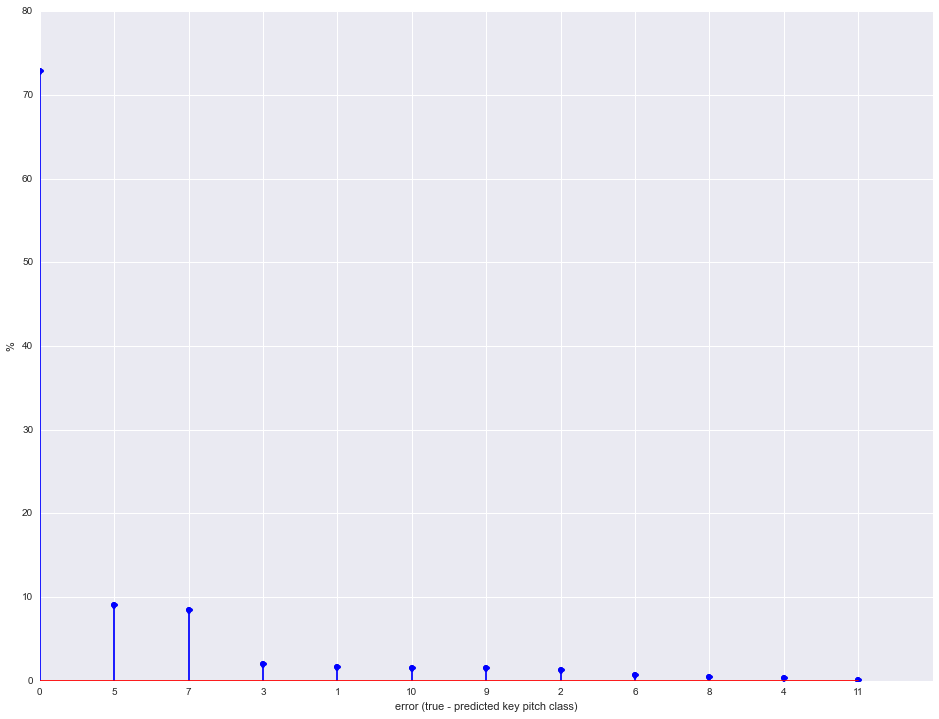

In [96]:
theano_accuracy_report(exp.network)

In [102]:
exp.save('data/beatles/models/chords_keys_synth_theano_01.model')

INFO:theanets.graph:data/beatles/models/chords_keys_synth_theano_01.model: saved model


I 2015-09-22 22:09:42 theanets.graph:470 data/beatles/models/chords_keys_synth_theano_01.model: saved model


In [77]:
# two hidden layers of size 100, autoencoer pretraining, no regularization
exp02 = theanets.Experiment(theanets.Classifier, layers=[X.shape[1], 100, 12])
exp02.train(
    (X_train.astype(float32),y_train),
    (X_valid.astype(float32),y_valid),
    algo='pretraining', learning_rate=1e-4, momentum=0.9)

INFO:theanets.layers.feedforward:layer Input "in": 192 inputs


I 2015-09-22 21:10:08 theanets.layers.feedforward:41 layer Input "in": 192 inputs


INFO:theanets.layers.base:layer Feedforward "hid1": (in:out)192 -> 100, logistic, 19300 parameters


I 2015-09-22 21:10:08 theanets.layers.base:316 layer Feedforward "hid1": (in:out)192 -> 100, logistic, 19300 parameters


INFO:theanets.layers.base:layer Feedforward "out": (hid1:out)100 -> 12, softmax, 1212 parameters


I 2015-09-22 21:10:08 theanets.layers.base:316 layer Feedforward "out": (hid1:out)100 -> 12, softmax, 1212 parameters


INFO:theanets.graph:network has 20512 total parameters


I 2015-09-22 21:10:08 theanets.graph:114 network has 20512 total parameters


INFO:downhill.dataset:valid: 1083 of 1083 mini-batches of (32, 192); (32,)


I 2015-09-22 21:10:08 downhill.dataset:144 valid: 1083 of 1083 mini-batches of (32, 192); (32,)


INFO:downhill.dataset:train: 3249 of 3249 mini-batches of (32, 192); (32,)


I 2015-09-22 21:10:08 downhill.dataset:144 train: 3249 of 3249 mini-batches of (32, 192); (32,)


INFO:downhill.base:-- patience = 5


I 2015-09-22 21:10:08 downhill.base:378 -- patience = 5


INFO:downhill.base:-- validate_every = 10


I 2015-09-22 21:10:08 downhill.base:379 -- validate_every = 10


INFO:downhill.base:-- min_improvement = 0


I 2015-09-22 21:10:08 downhill.base:380 -- min_improvement = 0


INFO:downhill.base:-- max_gradient_norm = 0


I 2015-09-22 21:10:08 downhill.base:381 -- max_gradient_norm = 0


INFO:downhill.base:-- max_gradient_elem = 0


I 2015-09-22 21:10:08 downhill.base:382 -- max_gradient_elem = 0


INFO:downhill.base:-- learning_rate = 0.0001


I 2015-09-22 21:10:08 downhill.base:383 -- learning_rate = 0.0001


INFO:downhill.base:-- momentum = 0.9


I 2015-09-22 21:10:08 downhill.base:384 -- momentum = 0.9


INFO:downhill.base:-- nesterov = False


I 2015-09-22 21:10:08 downhill.base:385 -- nesterov = False


INFO:downhill.adaptive:-- rms_halflife = 14


I 2015-09-22 21:10:08 downhill.adaptive:220 -- rms_halflife = 14


INFO:downhill.adaptive:-- rms_regularizer = 1e-08


I 2015-09-22 21:10:08 downhill.adaptive:221 -- rms_regularizer = 1e-08


INFO:downhill.base:compiling evaluation function


I 2015-09-22 21:10:08 downhill.base:112 compiling evaluation function


INFO:downhill.base:compiling RMSProp function


I 2015-09-22 21:10:10 downhill.base:118 compiling RMSProp function


INFO:downhill.base:validation 0 loss=3.061227 err=3.061227 acc=0.084632 *


I 2015-09-22 21:10:13 downhill.base:226 validation 0 loss=3.061227 err=3.061227 acc=0.084632 *


INFO:downhill.base:RMSProp 1 loss=0.990295 err=0.990295 acc=0.726495


I 2015-09-22 21:10:16 downhill.base:226 RMSProp 1 loss=0.990295 err=0.990295 acc=0.726495


INFO:downhill.base:RMSProp 2 loss=0.834510 err=0.834510 acc=0.751580


I 2015-09-22 21:10:19 downhill.base:226 RMSProp 2 loss=0.834510 err=0.834510 acc=0.751580


INFO:downhill.base:RMSProp 3 loss=0.784133 err=0.784133 acc=0.761101


I 2015-09-22 21:10:22 downhill.base:226 RMSProp 3 loss=0.784133 err=0.784133 acc=0.761101


INFO:downhill.base:RMSProp 4 loss=0.752851 err=0.752851 acc=0.767729


I 2015-09-22 21:10:24 downhill.base:226 RMSProp 4 loss=0.752851 err=0.752851 acc=0.767729


INFO:downhill.base:RMSProp 5 loss=0.729180 err=0.729180 acc=0.774395


I 2015-09-22 21:10:27 downhill.base:226 RMSProp 5 loss=0.729180 err=0.729180 acc=0.774395


INFO:downhill.base:RMSProp 6 loss=0.710382 err=0.710382 acc=0.779407


I 2015-09-22 21:10:29 downhill.base:226 RMSProp 6 loss=0.710382 err=0.710382 acc=0.779407


INFO:downhill.base:RMSProp 7 loss=0.693436 err=0.693436 acc=0.783666


I 2015-09-22 21:10:32 downhill.base:226 RMSProp 7 loss=0.693436 err=0.693436 acc=0.783666


INFO:downhill.base:RMSProp 8 loss=0.677871 err=0.677871 acc=0.788716


I 2015-09-22 21:10:35 downhill.base:226 RMSProp 8 loss=0.677871 err=0.677871 acc=0.788716


INFO:downhill.base:RMSProp 9 loss=0.663869 err=0.663869 acc=0.792025


I 2015-09-22 21:10:37 downhill.base:226 RMSProp 9 loss=0.663869 err=0.663869 acc=0.792025


INFO:downhill.base:RMSProp 10 loss=0.650934 err=0.650934 acc=0.796806


I 2015-09-22 21:10:40 downhill.base:226 RMSProp 10 loss=0.650934 err=0.650934 acc=0.796806


INFO:downhill.base:validation 1 loss=0.700569 err=0.700569 acc=0.784078 *


I 2015-09-22 21:10:40 downhill.base:226 validation 1 loss=0.700569 err=0.700569 acc=0.784078 *


INFO:downhill.base:RMSProp 11 loss=0.638698 err=0.638698 acc=0.801153


I 2015-09-22 21:10:43 downhill.base:226 RMSProp 11 loss=0.638698 err=0.638698 acc=0.801153


INFO:downhill.base:RMSProp 12 loss=0.627088 err=0.627088 acc=0.804596


I 2015-09-22 21:10:46 downhill.base:226 RMSProp 12 loss=0.627088 err=0.627088 acc=0.804596


INFO:downhill.base:RMSProp 13 loss=0.616982 err=0.616982 acc=0.807375


I 2015-09-22 21:10:49 downhill.base:226 RMSProp 13 loss=0.616982 err=0.616982 acc=0.807375


INFO:downhill.base:RMSProp 14 loss=0.607168 err=0.607168 acc=0.810185


I 2015-09-22 21:10:52 downhill.base:226 RMSProp 14 loss=0.607168 err=0.607168 acc=0.810185


INFO:downhill.base:RMSProp 15 loss=0.597838 err=0.597838 acc=0.813955


I 2015-09-22 21:10:55 downhill.base:226 RMSProp 15 loss=0.597838 err=0.597838 acc=0.813955


INFO:downhill.base:RMSProp 16 loss=0.589798 err=0.589798 acc=0.815715


I 2015-09-22 21:10:58 downhill.base:226 RMSProp 16 loss=0.589798 err=0.589798 acc=0.815715


INFO:downhill.base:RMSProp 17 loss=0.582369 err=0.582369 acc=0.818303


I 2015-09-22 21:11:00 downhill.base:226 RMSProp 17 loss=0.582369 err=0.582369 acc=0.818303


INFO:downhill.base:RMSProp 18 loss=0.575377 err=0.575377 acc=0.821081


I 2015-09-22 21:11:03 downhill.base:226 RMSProp 18 loss=0.575377 err=0.575377 acc=0.821081


INFO:downhill.base:RMSProp 19 loss=0.568472 err=0.568472 acc=0.823392


I 2015-09-22 21:11:06 downhill.base:226 RMSProp 19 loss=0.568472 err=0.568472 acc=0.823392


INFO:downhill.base:RMSProp 20 loss=0.562110 err=0.562110 acc=0.825382


I 2015-09-22 21:11:08 downhill.base:226 RMSProp 20 loss=0.562110 err=0.562110 acc=0.825382


INFO:downhill.base:validation 2 loss=0.691086 err=0.691086 acc=0.790945 *


I 2015-09-22 21:11:09 downhill.base:226 validation 2 loss=0.691086 err=0.691086 acc=0.790945 *


INFO:downhill.base:RMSProp 21 loss=0.556801 err=0.556801 acc=0.826978


I 2015-09-22 21:11:12 downhill.base:226 RMSProp 21 loss=0.556801 err=0.556801 acc=0.826978


INFO:downhill.base:RMSProp 22 loss=0.551639 err=0.551639 acc=0.828700


I 2015-09-22 21:11:15 downhill.base:226 RMSProp 22 loss=0.551639 err=0.551639 acc=0.828700


INFO:downhill.base:RMSProp 23 loss=0.546399 err=0.546399 acc=0.830690


I 2015-09-22 21:11:18 downhill.base:226 RMSProp 23 loss=0.546399 err=0.546399 acc=0.830690


INFO:downhill.base:RMSProp 24 loss=0.541094 err=0.541094 acc=0.832681


I 2015-09-22 21:11:21 downhill.base:226 RMSProp 24 loss=0.541094 err=0.541094 acc=0.832681


INFO:downhill.base:RMSProp 25 loss=0.537590 err=0.537590 acc=0.832624


I 2015-09-22 21:11:24 downhill.base:226 RMSProp 25 loss=0.537590 err=0.537590 acc=0.832624


INFO:downhill.base:RMSProp 26 loss=0.533278 err=0.533278 acc=0.834768


I 2015-09-22 21:11:27 downhill.base:226 RMSProp 26 loss=0.533278 err=0.533278 acc=0.834768


INFO:downhill.base:RMSProp 27 loss=0.528871 err=0.528871 acc=0.836077


I 2015-09-22 21:11:30 downhill.base:226 RMSProp 27 loss=0.528871 err=0.528871 acc=0.836077


INFO:downhill.base:RMSProp 28 loss=0.525249 err=0.525249 acc=0.837021


I 2015-09-22 21:11:32 downhill.base:226 RMSProp 28 loss=0.525249 err=0.525249 acc=0.837021


INFO:downhill.base:RMSProp 29 loss=0.521410 err=0.521410 acc=0.838068


I 2015-09-22 21:11:35 downhill.base:226 RMSProp 29 loss=0.521410 err=0.521410 acc=0.838068


INFO:downhill.base:RMSProp 30 loss=0.518323 err=0.518323 acc=0.840090


I 2015-09-22 21:11:37 downhill.base:226 RMSProp 30 loss=0.518323 err=0.518323 acc=0.840090


INFO:downhill.base:validation 3 loss=0.706092 err=0.706092 acc=0.791811


I 2015-09-22 21:11:37 downhill.base:226 validation 3 loss=0.706092 err=0.706092 acc=0.791811


INFO:downhill.base:RMSProp 31 loss=0.515352 err=0.515352 acc=0.840935


I 2015-09-22 21:11:40 downhill.base:226 RMSProp 31 loss=0.515352 err=0.515352 acc=0.840935


INFO:downhill.base:RMSProp 32 loss=0.511889 err=0.511889 acc=0.840945


I 2015-09-22 21:11:43 downhill.base:226 RMSProp 32 loss=0.511889 err=0.511889 acc=0.840945


INFO:downhill.base:RMSProp 33 loss=0.509321 err=0.509321 acc=0.842638


I 2015-09-22 21:11:45 downhill.base:226 RMSProp 33 loss=0.509321 err=0.509321 acc=0.842638


INFO:downhill.base:RMSProp 34 loss=0.506315 err=0.506315 acc=0.843126


I 2015-09-22 21:11:48 downhill.base:226 RMSProp 34 loss=0.506315 err=0.506315 acc=0.843126


INFO:downhill.base:RMSProp 35 loss=0.502970 err=0.502970 acc=0.844781


I 2015-09-22 21:11:51 downhill.base:226 RMSProp 35 loss=0.502970 err=0.502970 acc=0.844781


INFO:downhill.base:RMSProp 36 loss=0.500946 err=0.500946 acc=0.845766


I 2015-09-22 21:11:54 downhill.base:226 RMSProp 36 loss=0.500946 err=0.500946 acc=0.845766


INFO:downhill.base:RMSProp 37 loss=0.499128 err=0.499128 acc=0.845821


I 2015-09-22 21:11:57 downhill.base:226 RMSProp 37 loss=0.499128 err=0.499128 acc=0.845821


INFO:downhill.base:RMSProp 38 loss=0.496116 err=0.496116 acc=0.846554


I 2015-09-22 21:12:00 downhill.base:226 RMSProp 38 loss=0.496116 err=0.496116 acc=0.846554


INFO:downhill.base:RMSProp 39 loss=0.493522 err=0.493522 acc=0.847139


I 2015-09-22 21:12:03 downhill.base:226 RMSProp 39 loss=0.493522 err=0.493522 acc=0.847139


INFO:downhill.base:RMSProp 40 loss=0.491133 err=0.491133 acc=0.848717


I 2015-09-22 21:12:06 downhill.base:226 RMSProp 40 loss=0.491133 err=0.491133 acc=0.848717


INFO:downhill.base:validation 4 loss=0.723751 err=0.723751 acc=0.789733


I 2015-09-22 21:12:06 downhill.base:226 validation 4 loss=0.723751 err=0.723751 acc=0.789733


INFO:downhill.base:RMSProp 41 loss=0.488863 err=0.488863 acc=0.849534


I 2015-09-22 21:12:09 downhill.base:226 RMSProp 41 loss=0.488863 err=0.488863 acc=0.849534


INFO:downhill.base:RMSProp 42 loss=0.486897 err=0.486897 acc=0.849977


I 2015-09-22 21:12:13 downhill.base:226 RMSProp 42 loss=0.486897 err=0.486897 acc=0.849977


INFO:downhill.base:RMSProp 43 loss=0.484993 err=0.484993 acc=0.849370


I 2015-09-22 21:12:16 downhill.base:226 RMSProp 43 loss=0.484993 err=0.484993 acc=0.849370


INFO:downhill.base:RMSProp 44 loss=0.482839 err=0.482839 acc=0.851113


I 2015-09-22 21:12:19 downhill.base:226 RMSProp 44 loss=0.482839 err=0.482839 acc=0.851113


INFO:downhill.base:RMSProp 45 loss=0.481664 err=0.481664 acc=0.851292


I 2015-09-22 21:12:21 downhill.base:226 RMSProp 45 loss=0.481664 err=0.481664 acc=0.851292


INFO:downhill.base:RMSProp 46 loss=0.479087 err=0.479087 acc=0.852179


I 2015-09-22 21:12:24 downhill.base:226 RMSProp 46 loss=0.479087 err=0.479087 acc=0.852179


INFO:downhill.base:RMSProp 47 loss=0.477889 err=0.477889 acc=0.852854


I 2015-09-22 21:12:26 downhill.base:226 RMSProp 47 loss=0.477889 err=0.477889 acc=0.852854


INFO:downhill.base:RMSProp 48 loss=0.475876 err=0.475876 acc=0.853265


I 2015-09-22 21:12:29 downhill.base:226 RMSProp 48 loss=0.475876 err=0.475876 acc=0.853265


INFO:downhill.base:RMSProp 49 loss=0.474521 err=0.474521 acc=0.853728


I 2015-09-22 21:12:31 downhill.base:226 RMSProp 49 loss=0.474521 err=0.474521 acc=0.853728


INFO:downhill.base:RMSProp 50 loss=0.472296 err=0.472296 acc=0.853969


I 2015-09-22 21:12:34 downhill.base:226 RMSProp 50 loss=0.472296 err=0.472296 acc=0.853969


INFO:downhill.base:validation 5 loss=0.750334 err=0.750334 acc=0.785607


I 2015-09-22 21:12:34 downhill.base:226 validation 5 loss=0.750334 err=0.750334 acc=0.785607


INFO:downhill.base:RMSProp 51 loss=0.470513 err=0.470513 acc=0.854681


I 2015-09-22 21:12:37 downhill.base:226 RMSProp 51 loss=0.470513 err=0.470513 acc=0.854681


INFO:downhill.base:RMSProp 52 loss=0.468879 err=0.468879 acc=0.855499


I 2015-09-22 21:12:40 downhill.base:226 RMSProp 52 loss=0.468879 err=0.468879 acc=0.855499


INFO:downhill.base:RMSProp 53 loss=0.467853 err=0.467853 acc=0.855583


I 2015-09-22 21:12:42 downhill.base:226 RMSProp 53 loss=0.467853 err=0.467853 acc=0.855583


INFO:downhill.base:RMSProp 54 loss=0.466314 err=0.466314 acc=0.855660


I 2015-09-22 21:12:45 downhill.base:226 RMSProp 54 loss=0.466314 err=0.466314 acc=0.855660


INFO:downhill.base:RMSProp 55 loss=0.464907 err=0.464907 acc=0.857152


I 2015-09-22 21:12:48 downhill.base:226 RMSProp 55 loss=0.464907 err=0.464907 acc=0.857152


INFO:downhill.base:RMSProp 56 loss=0.462803 err=0.462803 acc=0.857460


I 2015-09-22 21:12:51 downhill.base:226 RMSProp 56 loss=0.462803 err=0.462803 acc=0.857460


INFO:downhill.base:RMSProp 57 loss=0.462073 err=0.462073 acc=0.858171


I 2015-09-22 21:12:55 downhill.base:226 RMSProp 57 loss=0.462073 err=0.462073 acc=0.858171


INFO:downhill.base:RMSProp 58 loss=0.461382 err=0.461382 acc=0.857565


I 2015-09-22 21:12:58 downhill.base:226 RMSProp 58 loss=0.461382 err=0.461382 acc=0.857565


INFO:downhill.base:RMSProp 59 loss=0.458700 err=0.458700 acc=0.858576


I 2015-09-22 21:13:01 downhill.base:226 RMSProp 59 loss=0.458700 err=0.458700 acc=0.858576


INFO:downhill.base:RMSProp 60 loss=0.457813 err=0.457813 acc=0.858354


I 2015-09-22 21:13:04 downhill.base:226 RMSProp 60 loss=0.457813 err=0.457813 acc=0.858354


INFO:downhill.base:validation 6 loss=0.775764 err=0.775764 acc=0.783039


I 2015-09-22 21:13:04 downhill.base:226 validation 6 loss=0.775764 err=0.775764 acc=0.783039


INFO:downhill.base:RMSProp 61 loss=0.456298 err=0.456298 acc=0.859989


I 2015-09-22 21:13:08 downhill.base:226 RMSProp 61 loss=0.456298 err=0.456298 acc=0.859989


INFO:downhill.base:RMSProp 62 loss=0.455526 err=0.455526 acc=0.859691


I 2015-09-22 21:13:10 downhill.base:226 RMSProp 62 loss=0.455526 err=0.455526 acc=0.859691


INFO:downhill.base:RMSProp 63 loss=0.454037 err=0.454037 acc=0.860779


I 2015-09-22 21:13:13 downhill.base:226 RMSProp 63 loss=0.454037 err=0.454037 acc=0.860779


INFO:downhill.base:RMSProp 64 loss=0.453662 err=0.453662 acc=0.861634


I 2015-09-22 21:13:15 downhill.base:226 RMSProp 64 loss=0.453662 err=0.453662 acc=0.861634


INFO:downhill.base:RMSProp 65 loss=0.452126 err=0.452126 acc=0.861153


I 2015-09-22 21:13:18 downhill.base:226 RMSProp 65 loss=0.452126 err=0.452126 acc=0.861153


INFO:downhill.base:RMSProp 66 loss=0.450701 err=0.450701 acc=0.861710


I 2015-09-22 21:13:21 downhill.base:226 RMSProp 66 loss=0.450701 err=0.450701 acc=0.861710


INFO:downhill.base:RMSProp 67 loss=0.449561 err=0.449561 acc=0.862163


I 2015-09-22 21:13:24 downhill.base:226 RMSProp 67 loss=0.449561 err=0.449561 acc=0.862163


INFO:downhill.base:RMSProp 68 loss=0.448446 err=0.448446 acc=0.863114


I 2015-09-22 21:13:27 downhill.base:226 RMSProp 68 loss=0.448446 err=0.448446 acc=0.863114


INFO:downhill.base:RMSProp 69 loss=0.447633 err=0.447633 acc=0.862182


I 2015-09-22 21:13:29 downhill.base:226 RMSProp 69 loss=0.447633 err=0.447633 acc=0.862182


INFO:downhill.base:RMSProp 70 loss=0.447253 err=0.447253 acc=0.863251


I 2015-09-22 21:13:32 downhill.base:226 RMSProp 70 loss=0.447253 err=0.447253 acc=0.863251


INFO:downhill.base:validation 7 loss=0.797328 err=0.797328 acc=0.783674


I 2015-09-22 21:13:32 downhill.base:226 validation 7 loss=0.797328 err=0.797328 acc=0.783674


INFO:downhill.base:RMSProp 71 loss=0.445966 err=0.445966 acc=0.862625


I 2015-09-22 21:13:34 downhill.base:226 RMSProp 71 loss=0.445966 err=0.445966 acc=0.862625


INFO:downhill.base:RMSProp 72 loss=0.444749 err=0.444749 acc=0.863625


I 2015-09-22 21:13:37 downhill.base:226 RMSProp 72 loss=0.444749 err=0.444749 acc=0.863625


INFO:downhill.base:RMSProp 73 loss=0.443551 err=0.443551 acc=0.864000


I 2015-09-22 21:13:40 downhill.base:226 RMSProp 73 loss=0.443551 err=0.443551 acc=0.864000


INFO:downhill.base:RMSProp 74 loss=0.442668 err=0.442668 acc=0.863684


I 2015-09-22 21:13:42 downhill.base:226 RMSProp 74 loss=0.442668 err=0.442668 acc=0.863684


INFO:downhill.base:RMSProp 75 loss=0.441872 err=0.441872 acc=0.864625


I 2015-09-22 21:13:45 downhill.base:226 RMSProp 75 loss=0.441872 err=0.441872 acc=0.864625


INFO:downhill.base:RMSProp 76 loss=0.440991 err=0.440991 acc=0.865021


I 2015-09-22 21:13:48 downhill.base:226 RMSProp 76 loss=0.440991 err=0.440991 acc=0.865021


INFO:downhill.base:RMSProp 77 loss=0.439715 err=0.439715 acc=0.865116


I 2015-09-22 21:13:51 downhill.base:226 RMSProp 77 loss=0.439715 err=0.439715 acc=0.865116


INFO:downhill.base:RMSProp 78 loss=0.439554 err=0.439554 acc=0.866031


I 2015-09-22 21:13:54 downhill.base:226 RMSProp 78 loss=0.439554 err=0.439554 acc=0.866031


INFO:downhill.base:RMSProp 79 loss=0.438084 err=0.438084 acc=0.865886


I 2015-09-22 21:13:56 downhill.base:226 RMSProp 79 loss=0.438084 err=0.438084 acc=0.865886


INFO:downhill.base:RMSProp 80 loss=0.437310 err=0.437310 acc=0.865107


I 2015-09-22 21:14:00 downhill.base:226 RMSProp 80 loss=0.437310 err=0.437310 acc=0.865107


INFO:downhill.base:validation 8 loss=0.817045 err=0.817045 acc=0.780557


I 2015-09-22 21:14:00 downhill.base:226 validation 8 loss=0.817045 err=0.817045 acc=0.780557


INFO:downhill.base:patience elapsed!


I 2015-09-22 21:14:00 downhill.base:402 patience elapsed!


(OrderedDict([('loss', 0.4373099297977624), ('err', 0.4373099297977624), ('acc', 0.86510736725358472)]),
 OrderedDict([('loss', 0.7973277453240265), ('err', 0.7973277453240265), ('acc', 0.78367382271468145)]))

training score: 0.832934160535
validation score: 0.790945290859


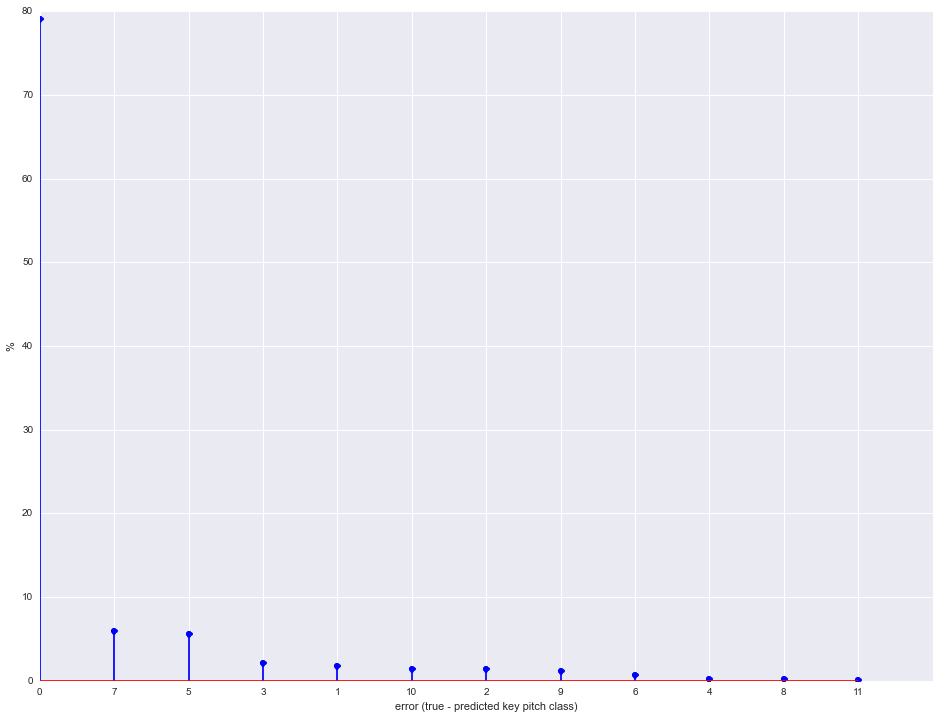

In [97]:
theano_accuracy_report(exp02.network)

In [104]:
exp02.save('data/beatles/models/chords_keys_synth_theano_02.model')

INFO:theanets.graph:data/beatles/models/chords_keys_synth_theano_02.model: saved model


I 2015-09-22 22:09:57 theanets.graph:470 data/beatles/models/chords_keys_synth_theano_02.model: saved model


INFO:theanets.layers.feedforward:layer Input "in": 192 inputs


I 2015-09-22 21:33:13 theanets.layers.feedforward:41 layer Input "in": 192 inputs


INFO:theanets.layers.base:layer Feedforward "hid1": (in:out)192 -> 100, logistic, 19300 parameters


I 2015-09-22 21:33:13 theanets.layers.base:316 layer Feedforward "hid1": (in:out)192 -> 100, logistic, 19300 parameters


INFO:theanets.layers.base:layer Feedforward "out": (hid1:out)100 -> 12, softmax, 1212 parameters


I 2015-09-22 21:33:13 theanets.layers.base:316 layer Feedforward "out": (hid1:out)100 -> 12, softmax, 1212 parameters


INFO:theanets.graph:network has 20512 total parameters


I 2015-09-22 21:33:13 theanets.graph:114 network has 20512 total parameters


INFO:downhill.dataset:valid: 1083 of 1083 mini-batches of (32, 192); (32,)


I 2015-09-22 21:33:13 downhill.dataset:144 valid: 1083 of 1083 mini-batches of (32, 192); (32,)


INFO:downhill.dataset:train: 3249 of 3249 mini-batches of (32, 192); (32,)


I 2015-09-22 21:33:13 downhill.dataset:144 train: 3249 of 3249 mini-batches of (32, 192); (32,)


INFO:downhill.base:-- patience = 5


I 2015-09-22 21:33:13 downhill.base:378 -- patience = 5


INFO:downhill.base:-- validate_every = 10


I 2015-09-22 21:33:13 downhill.base:379 -- validate_every = 10


INFO:downhill.base:-- min_improvement = 0


I 2015-09-22 21:33:13 downhill.base:380 -- min_improvement = 0


INFO:downhill.base:-- max_gradient_norm = 0


I 2015-09-22 21:33:13 downhill.base:381 -- max_gradient_norm = 0


INFO:downhill.base:-- max_gradient_elem = 0


I 2015-09-22 21:33:13 downhill.base:382 -- max_gradient_elem = 0


INFO:downhill.base:-- learning_rate = 0.0001


I 2015-09-22 21:33:13 downhill.base:383 -- learning_rate = 0.0001


INFO:downhill.base:-- momentum = 0.9


I 2015-09-22 21:33:13 downhill.base:384 -- momentum = 0.9


INFO:downhill.base:-- nesterov = False


I 2015-09-22 21:33:13 downhill.base:385 -- nesterov = False


INFO:downhill.adaptive:-- rms_halflife = 14


I 2015-09-22 21:33:13 downhill.adaptive:220 -- rms_halflife = 14


INFO:downhill.adaptive:-- rms_regularizer = 1e-08


I 2015-09-22 21:33:13 downhill.adaptive:221 -- rms_regularizer = 1e-08


INFO:downhill.base:compiling evaluation function


I 2015-09-22 21:33:13 downhill.base:112 compiling evaluation function


INFO:downhill.base:compiling RMSProp function


I 2015-09-22 21:33:13 downhill.base:118 compiling RMSProp function


INFO:downhill.base:validation 0 loss=3.129999 err=3.129999 acc=0.083708 *


I 2015-09-22 21:33:15 downhill.base:226 validation 0 loss=3.129999 err=3.129999 acc=0.083708 *


INFO:downhill.base:RMSProp 1 loss=0.982786 err=0.982786 acc=0.726408


I 2015-09-22 21:33:18 downhill.base:226 RMSProp 1 loss=0.982786 err=0.982786 acc=0.726408


INFO:downhill.base:RMSProp 2 loss=0.828139 err=0.828139 acc=0.751166


I 2015-09-22 21:33:22 downhill.base:226 RMSProp 2 loss=0.828139 err=0.828139 acc=0.751166


INFO:downhill.base:RMSProp 3 loss=0.781537 err=0.781537 acc=0.760612


I 2015-09-22 21:33:25 downhill.base:226 RMSProp 3 loss=0.781537 err=0.781537 acc=0.760612


INFO:downhill.base:RMSProp 4 loss=0.751381 err=0.751381 acc=0.767546


I 2015-09-22 21:33:28 downhill.base:226 RMSProp 4 loss=0.751381 err=0.751381 acc=0.767546


INFO:downhill.base:RMSProp 5 loss=0.728414 err=0.728414 acc=0.773684


I 2015-09-22 21:33:31 downhill.base:226 RMSProp 5 loss=0.728414 err=0.728414 acc=0.773684


INFO:downhill.base:RMSProp 6 loss=0.709894 err=0.709894 acc=0.778801


I 2015-09-22 21:33:34 downhill.base:226 RMSProp 6 loss=0.709894 err=0.709894 acc=0.778801


INFO:downhill.base:RMSProp 7 loss=0.693021 err=0.693021 acc=0.783773


I 2015-09-22 21:33:37 downhill.base:226 RMSProp 7 loss=0.693021 err=0.693021 acc=0.783773


INFO:downhill.base:RMSProp 8 loss=0.678755 err=0.678755 acc=0.787331


I 2015-09-22 21:33:39 downhill.base:226 RMSProp 8 loss=0.678755 err=0.678755 acc=0.787331


INFO:downhill.base:RMSProp 9 loss=0.664763 err=0.664763 acc=0.792555


I 2015-09-22 21:33:42 downhill.base:226 RMSProp 9 loss=0.664763 err=0.664763 acc=0.792555


INFO:downhill.base:RMSProp 10 loss=0.652719 err=0.652719 acc=0.796211


I 2015-09-22 21:33:45 downhill.base:226 RMSProp 10 loss=0.652719 err=0.652719 acc=0.796211


INFO:downhill.base:validation 1 loss=0.702708 err=0.702708 acc=0.782029 *


I 2015-09-22 21:33:45 downhill.base:226 validation 1 loss=0.702708 err=0.702708 acc=0.782029 *


INFO:downhill.base:RMSProp 11 loss=0.640963 err=0.640963 acc=0.800115


I 2015-09-22 21:33:48 downhill.base:226 RMSProp 11 loss=0.640963 err=0.640963 acc=0.800115


INFO:downhill.base:RMSProp 12 loss=0.629784 err=0.629784 acc=0.803472


I 2015-09-22 21:33:51 downhill.base:226 RMSProp 12 loss=0.629784 err=0.629784 acc=0.803472


INFO:downhill.base:RMSProp 13 loss=0.619569 err=0.619569 acc=0.806435


I 2015-09-22 21:33:54 downhill.base:226 RMSProp 13 loss=0.619569 err=0.619569 acc=0.806435


INFO:downhill.base:RMSProp 14 loss=0.609920 err=0.609920 acc=0.810917


I 2015-09-22 21:33:56 downhill.base:226 RMSProp 14 loss=0.609920 err=0.609920 acc=0.810917


INFO:downhill.base:RMSProp 15 loss=0.600936 err=0.600936 acc=0.813503


I 2015-09-22 21:34:00 downhill.base:226 RMSProp 15 loss=0.600936 err=0.600936 acc=0.813503


INFO:downhill.base:RMSProp 16 loss=0.592219 err=0.592219 acc=0.815764


I 2015-09-22 21:34:02 downhill.base:226 RMSProp 16 loss=0.592219 err=0.592219 acc=0.815764


INFO:downhill.base:RMSProp 17 loss=0.584867 err=0.584867 acc=0.818457


I 2015-09-22 21:34:05 downhill.base:226 RMSProp 17 loss=0.584867 err=0.584867 acc=0.818457


INFO:downhill.base:RMSProp 18 loss=0.577438 err=0.577438 acc=0.821102


I 2015-09-22 21:34:09 downhill.base:226 RMSProp 18 loss=0.577438 err=0.577438 acc=0.821102


INFO:downhill.base:RMSProp 19 loss=0.571053 err=0.571053 acc=0.821832


I 2015-09-22 21:34:13 downhill.base:226 RMSProp 19 loss=0.571053 err=0.571053 acc=0.821832


INFO:downhill.base:RMSProp 20 loss=0.564836 err=0.564836 acc=0.824854


I 2015-09-22 21:34:16 downhill.base:226 RMSProp 20 loss=0.564836 err=0.564836 acc=0.824854


INFO:downhill.base:validation 2 loss=0.694497 err=0.694497 acc=0.787540 *


I 2015-09-22 21:34:16 downhill.base:226 validation 2 loss=0.694497 err=0.694497 acc=0.787540 *


INFO:downhill.base:RMSProp 21 loss=0.559111 err=0.559111 acc=0.826941


I 2015-09-22 21:34:19 downhill.base:226 RMSProp 21 loss=0.559111 err=0.559111 acc=0.826941


INFO:downhill.base:RMSProp 22 loss=0.553686 err=0.553686 acc=0.828298


I 2015-09-22 21:34:22 downhill.base:226 RMSProp 22 loss=0.553686 err=0.553686 acc=0.828298


INFO:downhill.base:RMSProp 23 loss=0.548367 err=0.548367 acc=0.829663


I 2015-09-22 21:34:26 downhill.base:226 RMSProp 23 loss=0.548367 err=0.548367 acc=0.829663


INFO:downhill.base:RMSProp 24 loss=0.544032 err=0.544032 acc=0.831269


I 2015-09-22 21:34:28 downhill.base:226 RMSProp 24 loss=0.544032 err=0.544032 acc=0.831269


INFO:downhill.base:RMSProp 25 loss=0.539354 err=0.539354 acc=0.832067


I 2015-09-22 21:34:31 downhill.base:226 RMSProp 25 loss=0.539354 err=0.539354 acc=0.832067


INFO:downhill.base:RMSProp 26 loss=0.535004 err=0.535004 acc=0.833895


I 2015-09-22 21:34:33 downhill.base:226 RMSProp 26 loss=0.535004 err=0.535004 acc=0.833895


INFO:downhill.base:RMSProp 27 loss=0.530864 err=0.530864 acc=0.835395


I 2015-09-22 21:34:37 downhill.base:226 RMSProp 27 loss=0.530864 err=0.530864 acc=0.835395


INFO:downhill.base:RMSProp 28 loss=0.526694 err=0.526694 acc=0.836319


I 2015-09-22 21:34:39 downhill.base:226 RMSProp 28 loss=0.526694 err=0.526694 acc=0.836319


INFO:downhill.base:RMSProp 29 loss=0.523344 err=0.523344 acc=0.837127


I 2015-09-22 21:34:42 downhill.base:226 RMSProp 29 loss=0.523344 err=0.523344 acc=0.837127


INFO:downhill.base:RMSProp 30 loss=0.520100 err=0.520100 acc=0.838714


I 2015-09-22 21:34:45 downhill.base:226 RMSProp 30 loss=0.520100 err=0.520100 acc=0.838714


INFO:downhill.base:validation 3 loss=0.700443 err=0.700443 acc=0.790166


I 2015-09-22 21:34:45 downhill.base:226 validation 3 loss=0.700443 err=0.700443 acc=0.790166


INFO:downhill.base:RMSProp 31 loss=0.516322 err=0.516322 acc=0.840224


I 2015-09-22 21:34:47 downhill.base:226 RMSProp 31 loss=0.516322 err=0.516322 acc=0.840224


INFO:downhill.base:RMSProp 32 loss=0.514068 err=0.514068 acc=0.840762


I 2015-09-22 21:34:50 downhill.base:226 RMSProp 32 loss=0.514068 err=0.514068 acc=0.840762


INFO:downhill.base:RMSProp 33 loss=0.510770 err=0.510770 acc=0.841830


I 2015-09-22 21:34:53 downhill.base:226 RMSProp 33 loss=0.510770 err=0.510770 acc=0.841830


INFO:downhill.base:RMSProp 34 loss=0.507829 err=0.507829 acc=0.842830


I 2015-09-22 21:34:56 downhill.base:226 RMSProp 34 loss=0.507829 err=0.507829 acc=0.842830


INFO:downhill.base:RMSProp 35 loss=0.505716 err=0.505716 acc=0.843234


I 2015-09-22 21:34:59 downhill.base:226 RMSProp 35 loss=0.505716 err=0.505716 acc=0.843234


INFO:downhill.base:RMSProp 36 loss=0.503011 err=0.503011 acc=0.844696


I 2015-09-22 21:35:01 downhill.base:226 RMSProp 36 loss=0.503011 err=0.503011 acc=0.844696


INFO:downhill.base:RMSProp 37 loss=0.499832 err=0.499832 acc=0.845033


I 2015-09-22 21:35:05 downhill.base:226 RMSProp 37 loss=0.499832 err=0.499832 acc=0.845033


INFO:downhill.base:RMSProp 38 loss=0.497688 err=0.497688 acc=0.845331


I 2015-09-22 21:35:08 downhill.base:226 RMSProp 38 loss=0.497688 err=0.497688 acc=0.845331


INFO:downhill.base:RMSProp 39 loss=0.495581 err=0.495581 acc=0.846485


I 2015-09-22 21:35:11 downhill.base:226 RMSProp 39 loss=0.495581 err=0.495581 acc=0.846485


INFO:downhill.base:RMSProp 40 loss=0.493524 err=0.493524 acc=0.848024


I 2015-09-22 21:35:14 downhill.base:226 RMSProp 40 loss=0.493524 err=0.493524 acc=0.848024


INFO:downhill.base:validation 4 loss=0.732142 err=0.732142 acc=0.786328


I 2015-09-22 21:35:14 downhill.base:226 validation 4 loss=0.732142 err=0.732142 acc=0.786328


INFO:downhill.base:RMSProp 41 loss=0.491602 err=0.491602 acc=0.847447


I 2015-09-22 21:35:17 downhill.base:226 RMSProp 41 loss=0.491602 err=0.491602 acc=0.847447


INFO:downhill.base:RMSProp 42 loss=0.488982 err=0.488982 acc=0.849438


I 2015-09-22 21:35:19 downhill.base:226 RMSProp 42 loss=0.488982 err=0.488982 acc=0.849438


INFO:downhill.base:RMSProp 43 loss=0.487208 err=0.487208 acc=0.849544


I 2015-09-22 21:35:22 downhill.base:226 RMSProp 43 loss=0.487208 err=0.487208 acc=0.849544


INFO:downhill.base:RMSProp 44 loss=0.484786 err=0.484786 acc=0.850968


I 2015-09-22 21:35:25 downhill.base:226 RMSProp 44 loss=0.484786 err=0.484786 acc=0.850968


INFO:downhill.base:RMSProp 45 loss=0.483815 err=0.483815 acc=0.851440


I 2015-09-22 21:35:29 downhill.base:226 RMSProp 45 loss=0.483815 err=0.483815 acc=0.851440


INFO:downhill.base:RMSProp 46 loss=0.481623 err=0.481623 acc=0.851795


I 2015-09-22 21:35:32 downhill.base:226 RMSProp 46 loss=0.481623 err=0.481623 acc=0.851795


INFO:downhill.base:RMSProp 47 loss=0.480152 err=0.480152 acc=0.851852


I 2015-09-22 21:35:36 downhill.base:226 RMSProp 47 loss=0.480152 err=0.480152 acc=0.851852


INFO:downhill.base:RMSProp 48 loss=0.478543 err=0.478543 acc=0.852718


I 2015-09-22 21:35:39 downhill.base:226 RMSProp 48 loss=0.478543 err=0.478543 acc=0.852718


INFO:downhill.base:RMSProp 49 loss=0.477042 err=0.477042 acc=0.853372


I 2015-09-22 21:35:42 downhill.base:226 RMSProp 49 loss=0.477042 err=0.477042 acc=0.853372


INFO:downhill.base:RMSProp 50 loss=0.474917 err=0.474917 acc=0.853853


I 2015-09-22 21:35:45 downhill.base:226 RMSProp 50 loss=0.474917 err=0.474917 acc=0.853853


INFO:downhill.base:validation 5 loss=0.752278 err=0.752278 acc=0.784164


I 2015-09-22 21:35:45 downhill.base:226 validation 5 loss=0.752278 err=0.752278 acc=0.784164


INFO:downhill.base:RMSProp 51 loss=0.474338 err=0.474338 acc=0.853709


I 2015-09-22 21:35:47 downhill.base:226 RMSProp 51 loss=0.474338 err=0.474338 acc=0.853709


INFO:downhill.base:RMSProp 52 loss=0.472411 err=0.472411 acc=0.854680


I 2015-09-22 21:35:50 downhill.base:226 RMSProp 52 loss=0.472411 err=0.472411 acc=0.854680


INFO:downhill.base:RMSProp 53 loss=0.471243 err=0.471243 acc=0.854622


I 2015-09-22 21:35:52 downhill.base:226 RMSProp 53 loss=0.471243 err=0.471243 acc=0.854622


INFO:downhill.base:RMSProp 54 loss=0.469291 err=0.469291 acc=0.855691


I 2015-09-22 21:35:55 downhill.base:226 RMSProp 54 loss=0.469291 err=0.469291 acc=0.855691


INFO:downhill.base:RMSProp 55 loss=0.468112 err=0.468112 acc=0.856952


I 2015-09-22 21:35:57 downhill.base:226 RMSProp 55 loss=0.468112 err=0.468112 acc=0.856952


INFO:downhill.base:RMSProp 56 loss=0.466635 err=0.466635 acc=0.856613


I 2015-09-22 21:36:00 downhill.base:226 RMSProp 56 loss=0.466635 err=0.466635 acc=0.856613


INFO:downhill.base:RMSProp 57 loss=0.465100 err=0.465100 acc=0.856220


I 2015-09-22 21:36:03 downhill.base:226 RMSProp 57 loss=0.465100 err=0.465100 acc=0.856220


INFO:downhill.base:RMSProp 58 loss=0.464344 err=0.464344 acc=0.857211


I 2015-09-22 21:36:05 downhill.base:226 RMSProp 58 loss=0.464344 err=0.464344 acc=0.857211


INFO:downhill.base:RMSProp 59 loss=0.462572 err=0.462572 acc=0.858674


I 2015-09-22 21:36:08 downhill.base:226 RMSProp 59 loss=0.462572 err=0.462572 acc=0.858674


INFO:downhill.base:RMSProp 60 loss=0.461327 err=0.461327 acc=0.858347


I 2015-09-22 21:36:10 downhill.base:226 RMSProp 60 loss=0.461327 err=0.461327 acc=0.858347


INFO:downhill.base:validation 6 loss=0.773662 err=0.773662 acc=0.783530


I 2015-09-22 21:36:11 downhill.base:226 validation 6 loss=0.773662 err=0.773662 acc=0.783530


INFO:downhill.base:RMSProp 61 loss=0.460689 err=0.460689 acc=0.858606


I 2015-09-22 21:36:13 downhill.base:226 RMSProp 61 loss=0.460689 err=0.460689 acc=0.858606


INFO:downhill.base:RMSProp 62 loss=0.458956 err=0.458956 acc=0.859423


I 2015-09-22 21:36:16 downhill.base:226 RMSProp 62 loss=0.458956 err=0.458956 acc=0.859423


INFO:downhill.base:RMSProp 63 loss=0.458056 err=0.458056 acc=0.859771


I 2015-09-22 21:36:19 downhill.base:226 RMSProp 63 loss=0.458056 err=0.458056 acc=0.859771


INFO:downhill.base:RMSProp 64 loss=0.456913 err=0.456913 acc=0.859461


I 2015-09-22 21:36:23 downhill.base:226 RMSProp 64 loss=0.456913 err=0.456913 acc=0.859461


INFO:downhill.base:RMSProp 65 loss=0.455929 err=0.455929 acc=0.860299


I 2015-09-22 21:36:26 downhill.base:226 RMSProp 65 loss=0.455929 err=0.455929 acc=0.860299


INFO:downhill.base:RMSProp 66 loss=0.454681 err=0.454681 acc=0.860492


I 2015-09-22 21:36:30 downhill.base:226 RMSProp 66 loss=0.454681 err=0.454681 acc=0.860492


INFO:downhill.base:RMSProp 67 loss=0.453741 err=0.453741 acc=0.861214


I 2015-09-22 21:36:33 downhill.base:226 RMSProp 67 loss=0.453741 err=0.453741 acc=0.861214


INFO:downhill.base:RMSProp 68 loss=0.452925 err=0.452925 acc=0.862030


I 2015-09-22 21:36:35 downhill.base:226 RMSProp 68 loss=0.452925 err=0.452925 acc=0.862030


INFO:downhill.base:RMSProp 69 loss=0.452019 err=0.452019 acc=0.862231


I 2015-09-22 21:36:38 downhill.base:226 RMSProp 69 loss=0.452019 err=0.452019 acc=0.862231


INFO:downhill.base:RMSProp 70 loss=0.450340 err=0.450340 acc=0.862059


I 2015-09-22 21:36:40 downhill.base:226 RMSProp 70 loss=0.450340 err=0.450340 acc=0.862059


INFO:downhill.base:validation 7 loss=0.795075 err=0.795075 acc=0.780904


I 2015-09-22 21:36:41 downhill.base:226 validation 7 loss=0.795075 err=0.795075 acc=0.780904


INFO:downhill.base:RMSProp 71 loss=0.450045 err=0.450045 acc=0.862358


I 2015-09-22 21:36:43 downhill.base:226 RMSProp 71 loss=0.450045 err=0.450045 acc=0.862358


INFO:downhill.base:RMSProp 72 loss=0.449250 err=0.449250 acc=0.862243


I 2015-09-22 21:36:46 downhill.base:226 RMSProp 72 loss=0.449250 err=0.449250 acc=0.862243


INFO:downhill.base:RMSProp 73 loss=0.448008 err=0.448008 acc=0.862733


I 2015-09-22 21:36:48 downhill.base:226 RMSProp 73 loss=0.448008 err=0.448008 acc=0.862733


INFO:downhill.base:RMSProp 74 loss=0.446889 err=0.446889 acc=0.863579


I 2015-09-22 21:36:52 downhill.base:226 RMSProp 74 loss=0.446889 err=0.446889 acc=0.863579


INFO:downhill.base:RMSProp 75 loss=0.446306 err=0.446306 acc=0.863792


I 2015-09-22 21:36:55 downhill.base:226 RMSProp 75 loss=0.446306 err=0.446306 acc=0.863792


INFO:downhill.base:RMSProp 76 loss=0.445537 err=0.445537 acc=0.863627


I 2015-09-22 21:36:57 downhill.base:226 RMSProp 76 loss=0.445537 err=0.445537 acc=0.863627


INFO:downhill.base:RMSProp 77 loss=0.444171 err=0.444171 acc=0.864752


I 2015-09-22 21:37:01 downhill.base:226 RMSProp 77 loss=0.444171 err=0.444171 acc=0.864752


INFO:downhill.base:RMSProp 78 loss=0.443748 err=0.443748 acc=0.864945


I 2015-09-22 21:37:04 downhill.base:226 RMSProp 78 loss=0.443748 err=0.443748 acc=0.864945


INFO:downhill.base:RMSProp 79 loss=0.442534 err=0.442534 acc=0.864637


I 2015-09-22 21:37:07 downhill.base:226 RMSProp 79 loss=0.442534 err=0.442534 acc=0.864637


INFO:downhill.base:RMSProp 80 loss=0.441827 err=0.441827 acc=0.864809


I 2015-09-22 21:37:10 downhill.base:226 RMSProp 80 loss=0.441827 err=0.441827 acc=0.864809


INFO:downhill.base:validation 8 loss=0.816560 err=0.816560 acc=0.780211


I 2015-09-22 21:37:10 downhill.base:226 validation 8 loss=0.816560 err=0.816560 acc=0.780211


INFO:downhill.base:patience elapsed!


I 2015-09-22 21:37:10 downhill.base:402 patience elapsed!


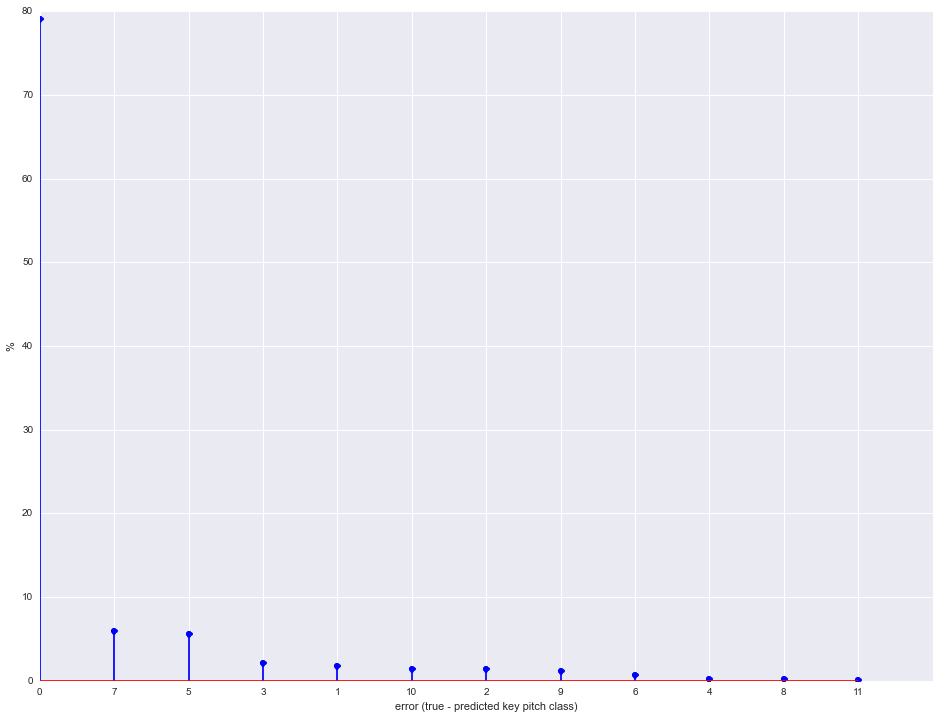

In [83]:
# on hidden layer of size 100, dropout regularization
exp03 = theanets.Experiment(theanets.Classifier, layers=[X.shape[1], 100, 12])
exp03.train(
    (X_train.astype(float32),y_train),
    (X_valid.astype(float32),y_valid),
    algo='pretraining', learning_rate=1e-4, momentum=0.9, input_dropout=0.5)

training score: 0.828759678738
validation score: 0.787540397045


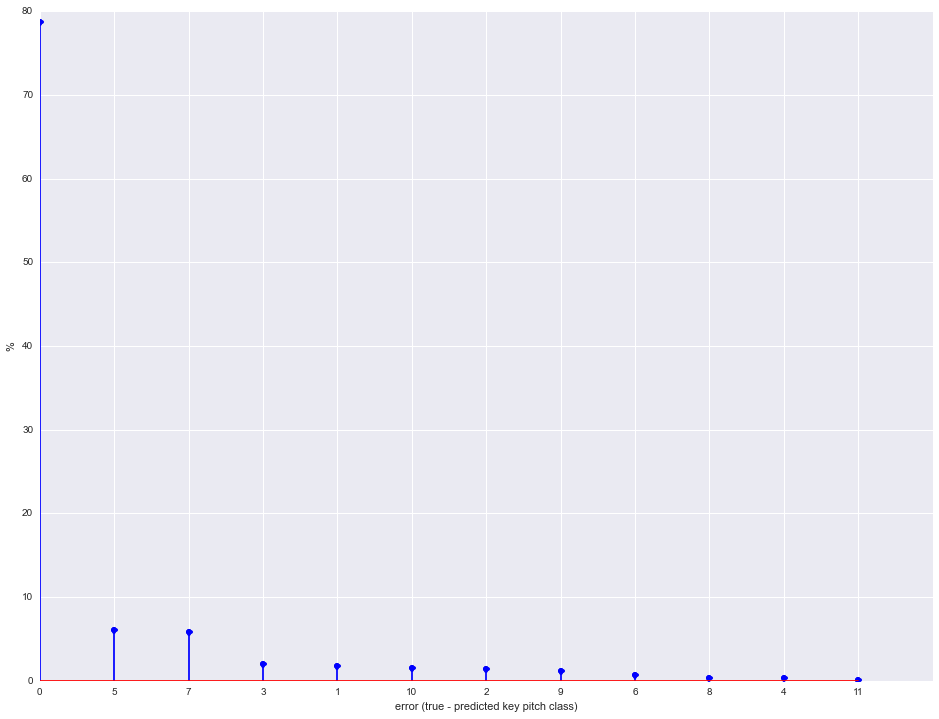

In [98]:
theano_accuracy_report(exp03.network)

In [105]:
exp03.save('data/beatles/models/chords_keys_synth_theano_03.model')

INFO:theanets.graph:data/beatles/models/chords_keys_synth_theano_03.model: saved model


I 2015-09-22 22:10:10 theanets.graph:470 data/beatles/models/chords_keys_synth_theano_03.model: saved model


In [100]:
# two hidden layers of size 100, dropout regularization
exp04 = theanets.Experiment(theanets.Classifier, layers=[X.shape[1], 100, 100, 12])
exp04.train(
    (X_train.astype(float32),y_train),
    (X_valid.astype(float32),y_valid),
    algo='pretraining', learning_rate=1e-4, momentum=0.9, input_dropout=0.5)

INFO:theanets.layers.feedforward:layer Input "in": 192 inputs


I 2015-09-22 21:58:11 theanets.layers.feedforward:41 layer Input "in": 192 inputs


INFO:theanets.layers.base:layer Feedforward "hid1": (in:out)192 -> 100, logistic, 19300 parameters


I 2015-09-22 21:58:11 theanets.layers.base:316 layer Feedforward "hid1": (in:out)192 -> 100, logistic, 19300 parameters


INFO:theanets.layers.base:layer Feedforward "hid2": (hid1:out)100 -> 100, logistic, 10100 parameters


I 2015-09-22 21:58:11 theanets.layers.base:316 layer Feedforward "hid2": (hid1:out)100 -> 100, logistic, 10100 parameters


INFO:theanets.layers.base:layer Feedforward "out": (hid2:out)100 -> 12, softmax, 1212 parameters


I 2015-09-22 21:58:11 theanets.layers.base:316 layer Feedforward "out": (hid2:out)100 -> 12, softmax, 1212 parameters


INFO:theanets.graph:network has 30612 total parameters


I 2015-09-22 21:58:11 theanets.graph:114 network has 30612 total parameters


INFO:downhill.dataset:valid: 1083 of 1083 mini-batches of (32, 192); (32,)


I 2015-09-22 21:58:11 downhill.dataset:144 valid: 1083 of 1083 mini-batches of (32, 192); (32,)


INFO:downhill.dataset:train: 3249 of 3249 mini-batches of (32, 192); (32,)


I 2015-09-22 21:58:11 downhill.dataset:144 train: 3249 of 3249 mini-batches of (32, 192); (32,)


INFO:downhill.base:-- patience = 5


I 2015-09-22 21:58:11 downhill.base:378 -- patience = 5


INFO:downhill.base:-- validate_every = 10


I 2015-09-22 21:58:11 downhill.base:379 -- validate_every = 10


INFO:downhill.base:-- min_improvement = 0


I 2015-09-22 21:58:11 downhill.base:380 -- min_improvement = 0


INFO:downhill.base:-- max_gradient_norm = 0


I 2015-09-22 21:58:11 downhill.base:381 -- max_gradient_norm = 0


INFO:downhill.base:-- max_gradient_elem = 0


I 2015-09-22 21:58:11 downhill.base:382 -- max_gradient_elem = 0


INFO:downhill.base:-- learning_rate = 0.0001


I 2015-09-22 21:58:11 downhill.base:383 -- learning_rate = 0.0001


INFO:downhill.base:-- momentum = 0.9


I 2015-09-22 21:58:11 downhill.base:384 -- momentum = 0.9


INFO:downhill.base:-- nesterov = False


I 2015-09-22 21:58:11 downhill.base:385 -- nesterov = False


INFO:downhill.adaptive:-- rms_halflife = 14


I 2015-09-22 21:58:11 downhill.adaptive:220 -- rms_halflife = 14


INFO:downhill.adaptive:-- rms_regularizer = 1e-08


I 2015-09-22 21:58:11 downhill.adaptive:221 -- rms_regularizer = 1e-08


INFO:downhill.base:compiling evaluation function


I 2015-09-22 21:58:11 downhill.base:112 compiling evaluation function


INFO:downhill.base:compiling RMSProp function


I 2015-09-22 21:58:12 downhill.base:118 compiling RMSProp function


INFO:downhill.base:validation 0 loss=3.702273 err=3.702273 acc=0.085440 *


I 2015-09-22 21:58:13 downhill.base:226 validation 0 loss=3.702273 err=3.702273 acc=0.085440 *


INFO:downhill.base:RMSProp 1 loss=1.021887 err=1.021887 acc=0.708526


I 2015-09-22 21:58:18 downhill.base:226 RMSProp 1 loss=1.021887 err=1.021887 acc=0.708526


INFO:downhill.base:RMSProp 2 loss=0.832367 err=0.832367 acc=0.749224


I 2015-09-22 21:58:22 downhill.base:226 RMSProp 2 loss=0.832367 err=0.832367 acc=0.749224


INFO:downhill.base:RMSProp 3 loss=0.785123 err=0.785123 acc=0.760669


I 2015-09-22 21:58:27 downhill.base:226 RMSProp 3 loss=0.785123 err=0.785123 acc=0.760669


INFO:downhill.base:RMSProp 4 loss=0.754592 err=0.754592 acc=0.768133


I 2015-09-22 21:58:31 downhill.base:226 RMSProp 4 loss=0.754592 err=0.754592 acc=0.768133


INFO:downhill.base:RMSProp 5 loss=0.729357 err=0.729357 acc=0.773365


I 2015-09-22 21:58:34 downhill.base:226 RMSProp 5 loss=0.729357 err=0.729357 acc=0.773365


INFO:downhill.base:RMSProp 6 loss=0.709758 err=0.709758 acc=0.778655


I 2015-09-22 21:58:39 downhill.base:226 RMSProp 6 loss=0.709758 err=0.709758 acc=0.778655


INFO:downhill.base:RMSProp 7 loss=0.690384 err=0.690384 acc=0.783465


I 2015-09-22 21:58:43 downhill.base:226 RMSProp 7 loss=0.690384 err=0.690384 acc=0.783465


INFO:downhill.base:RMSProp 8 loss=0.671167 err=0.671167 acc=0.789302


I 2015-09-22 21:58:47 downhill.base:226 RMSProp 8 loss=0.671167 err=0.671167 acc=0.789302


INFO:downhill.base:RMSProp 9 loss=0.654722 err=0.654722 acc=0.795468


I 2015-09-22 21:58:50 downhill.base:226 RMSProp 9 loss=0.654722 err=0.654722 acc=0.795468


INFO:downhill.base:RMSProp 10 loss=0.638636 err=0.638636 acc=0.799845


I 2015-09-22 21:58:54 downhill.base:226 RMSProp 10 loss=0.638636 err=0.638636 acc=0.799845


INFO:downhill.base:validation 1 loss=0.678616 err=0.678616 acc=0.791147 *


I 2015-09-22 21:58:55 downhill.base:226 validation 1 loss=0.678616 err=0.678616 acc=0.791147 *


INFO:downhill.base:RMSProp 11 loss=0.623418 err=0.623418 acc=0.804779


I 2015-09-22 21:58:59 downhill.base:226 RMSProp 11 loss=0.623418 err=0.623418 acc=0.804779


INFO:downhill.base:RMSProp 12 loss=0.607773 err=0.607773 acc=0.810550


I 2015-09-22 21:59:03 downhill.base:226 RMSProp 12 loss=0.607773 err=0.607773 acc=0.810550


INFO:downhill.base:RMSProp 13 loss=0.593460 err=0.593460 acc=0.814706


I 2015-09-22 21:59:07 downhill.base:226 RMSProp 13 loss=0.593460 err=0.593460 acc=0.814706


INFO:downhill.base:RMSProp 14 loss=0.580413 err=0.580413 acc=0.818687


I 2015-09-22 21:59:11 downhill.base:226 RMSProp 14 loss=0.580413 err=0.580413 acc=0.818687


INFO:downhill.base:RMSProp 15 loss=0.566488 err=0.566488 acc=0.822988


I 2015-09-22 21:59:16 downhill.base:226 RMSProp 15 loss=0.566488 err=0.566488 acc=0.822988


INFO:downhill.base:RMSProp 16 loss=0.554938 err=0.554938 acc=0.826172


I 2015-09-22 21:59:20 downhill.base:226 RMSProp 16 loss=0.554938 err=0.554938 acc=0.826172


INFO:downhill.base:RMSProp 17 loss=0.544403 err=0.544403 acc=0.829017


I 2015-09-22 21:59:24 downhill.base:226 RMSProp 17 loss=0.544403 err=0.544403 acc=0.829017


INFO:downhill.base:RMSProp 18 loss=0.532372 err=0.532372 acc=0.833501


I 2015-09-22 21:59:28 downhill.base:226 RMSProp 18 loss=0.532372 err=0.532372 acc=0.833501


INFO:downhill.base:RMSProp 19 loss=0.522735 err=0.522735 acc=0.836299


I 2015-09-22 21:59:32 downhill.base:226 RMSProp 19 loss=0.522735 err=0.522735 acc=0.836299


INFO:downhill.base:RMSProp 20 loss=0.512385 err=0.512385 acc=0.838811


I 2015-09-22 21:59:36 downhill.base:226 RMSProp 20 loss=0.512385 err=0.512385 acc=0.838811


INFO:downhill.base:validation 2 loss=0.642438 err=0.642438 acc=0.806036 *


I 2015-09-22 21:59:36 downhill.base:226 validation 2 loss=0.642438 err=0.642438 acc=0.806036 *


INFO:downhill.base:RMSProp 21 loss=0.502806 err=0.502806 acc=0.841754


I 2015-09-22 21:59:40 downhill.base:226 RMSProp 21 loss=0.502806 err=0.502806 acc=0.841754


INFO:downhill.base:RMSProp 22 loss=0.494350 err=0.494350 acc=0.844235


I 2015-09-22 21:59:44 downhill.base:226 RMSProp 22 loss=0.494350 err=0.494350 acc=0.844235


INFO:downhill.base:RMSProp 23 loss=0.484886 err=0.484886 acc=0.846958


I 2015-09-22 21:59:48 downhill.base:226 RMSProp 23 loss=0.484886 err=0.484886 acc=0.846958


INFO:downhill.base:RMSProp 24 loss=0.477612 err=0.477612 acc=0.848641


I 2015-09-22 21:59:53 downhill.base:226 RMSProp 24 loss=0.477612 err=0.477612 acc=0.848641


INFO:downhill.base:RMSProp 25 loss=0.470577 err=0.470577 acc=0.851036


I 2015-09-22 21:59:57 downhill.base:226 RMSProp 25 loss=0.470577 err=0.470577 acc=0.851036


INFO:downhill.base:RMSProp 26 loss=0.462639 err=0.462639 acc=0.852864


I 2015-09-22 22:00:02 downhill.base:226 RMSProp 26 loss=0.462639 err=0.462639 acc=0.852864


INFO:downhill.base:RMSProp 27 loss=0.455272 err=0.455272 acc=0.856124


I 2015-09-22 22:00:06 downhill.base:226 RMSProp 27 loss=0.455272 err=0.455272 acc=0.856124


INFO:downhill.base:RMSProp 28 loss=0.449502 err=0.449502 acc=0.857807


I 2015-09-22 22:00:11 downhill.base:226 RMSProp 28 loss=0.449502 err=0.449502 acc=0.857807


INFO:downhill.base:RMSProp 29 loss=0.441883 err=0.441883 acc=0.860606


I 2015-09-22 22:00:14 downhill.base:226 RMSProp 29 loss=0.441883 err=0.441883 acc=0.860606


INFO:downhill.base:RMSProp 30 loss=0.434831 err=0.434831 acc=0.862165


I 2015-09-22 22:00:18 downhill.base:226 RMSProp 30 loss=0.434831 err=0.434831 acc=0.862165


INFO:downhill.base:validation 3 loss=0.638559 err=0.638559 acc=0.810826 *


I 2015-09-22 22:00:19 downhill.base:226 validation 3 loss=0.638559 err=0.638559 acc=0.810826 *


INFO:downhill.base:RMSProp 31 loss=0.428790 err=0.428790 acc=0.863463


I 2015-09-22 22:00:23 downhill.base:226 RMSProp 31 loss=0.428790 err=0.428790 acc=0.863463


INFO:downhill.base:RMSProp 32 loss=0.422871 err=0.422871 acc=0.865723


I 2015-09-22 22:00:28 downhill.base:226 RMSProp 32 loss=0.422871 err=0.422871 acc=0.865723


INFO:downhill.base:RMSProp 33 loss=0.417483 err=0.417483 acc=0.867743


I 2015-09-22 22:00:33 downhill.base:226 RMSProp 33 loss=0.417483 err=0.417483 acc=0.867743


INFO:downhill.base:RMSProp 34 loss=0.412464 err=0.412464 acc=0.868475


I 2015-09-22 22:00:38 downhill.base:226 RMSProp 34 loss=0.412464 err=0.412464 acc=0.868475


INFO:downhill.base:RMSProp 35 loss=0.406479 err=0.406479 acc=0.870907


I 2015-09-22 22:00:42 downhill.base:226 RMSProp 35 loss=0.406479 err=0.406479 acc=0.870907


INFO:downhill.base:RMSProp 36 loss=0.400405 err=0.400405 acc=0.872485


I 2015-09-22 22:00:47 downhill.base:226 RMSProp 36 loss=0.400405 err=0.400405 acc=0.872485


INFO:downhill.base:RMSProp 37 loss=0.396254 err=0.396254 acc=0.873967


I 2015-09-22 22:00:51 downhill.base:226 RMSProp 37 loss=0.396254 err=0.396254 acc=0.873967


INFO:downhill.base:RMSProp 38 loss=0.390471 err=0.390471 acc=0.875871


I 2015-09-22 22:00:56 downhill.base:226 RMSProp 38 loss=0.390471 err=0.390471 acc=0.875871


INFO:downhill.base:RMSProp 39 loss=0.386346 err=0.386346 acc=0.877150


I 2015-09-22 22:01:00 downhill.base:226 RMSProp 39 loss=0.386346 err=0.386346 acc=0.877150


INFO:downhill.base:RMSProp 40 loss=0.382261 err=0.382261 acc=0.878891


I 2015-09-22 22:01:04 downhill.base:226 RMSProp 40 loss=0.382261 err=0.382261 acc=0.878891


INFO:downhill.base:validation 4 loss=0.658112 err=0.658112 acc=0.809384


I 2015-09-22 22:01:04 downhill.base:226 validation 4 loss=0.658112 err=0.658112 acc=0.809384


INFO:downhill.base:RMSProp 41 loss=0.377572 err=0.377572 acc=0.879555


I 2015-09-22 22:01:10 downhill.base:226 RMSProp 41 loss=0.377572 err=0.377572 acc=0.879555


INFO:downhill.base:RMSProp 42 loss=0.372595 err=0.372595 acc=0.881036


I 2015-09-22 22:01:14 downhill.base:226 RMSProp 42 loss=0.372595 err=0.372595 acc=0.881036


INFO:downhill.base:RMSProp 43 loss=0.368699 err=0.368699 acc=0.882615


I 2015-09-22 22:01:18 downhill.base:226 RMSProp 43 loss=0.368699 err=0.368699 acc=0.882615


INFO:downhill.base:RMSProp 44 loss=0.364587 err=0.364587 acc=0.883931


I 2015-09-22 22:01:21 downhill.base:226 RMSProp 44 loss=0.364587 err=0.364587 acc=0.883931


INFO:downhill.base:RMSProp 45 loss=0.360402 err=0.360402 acc=0.885865


I 2015-09-22 22:01:25 downhill.base:226 RMSProp 45 loss=0.360402 err=0.360402 acc=0.885865


INFO:downhill.base:RMSProp 46 loss=0.356985 err=0.356985 acc=0.886759


I 2015-09-22 22:01:29 downhill.base:226 RMSProp 46 loss=0.356985 err=0.356985 acc=0.886759


INFO:downhill.base:RMSProp 47 loss=0.352788 err=0.352788 acc=0.888482


I 2015-09-22 22:01:33 downhill.base:226 RMSProp 47 loss=0.352788 err=0.352788 acc=0.888482


INFO:downhill.base:RMSProp 48 loss=0.349729 err=0.349729 acc=0.889829


I 2015-09-22 22:01:38 downhill.base:226 RMSProp 48 loss=0.349729 err=0.349729 acc=0.889829


INFO:downhill.base:RMSProp 49 loss=0.345766 err=0.345766 acc=0.890425


I 2015-09-22 22:01:43 downhill.base:226 RMSProp 49 loss=0.345766 err=0.345766 acc=0.890425


INFO:downhill.base:RMSProp 50 loss=0.341547 err=0.341547 acc=0.891906


I 2015-09-22 22:01:47 downhill.base:226 RMSProp 50 loss=0.341547 err=0.341547 acc=0.891906


INFO:downhill.base:validation 5 loss=0.672017 err=0.672017 acc=0.813193


I 2015-09-22 22:01:47 downhill.base:226 validation 5 loss=0.672017 err=0.672017 acc=0.813193


INFO:downhill.base:RMSProp 51 loss=0.338920 err=0.338920 acc=0.893792


I 2015-09-22 22:01:51 downhill.base:226 RMSProp 51 loss=0.338920 err=0.338920 acc=0.893792


INFO:downhill.base:RMSProp 52 loss=0.334530 err=0.334530 acc=0.894040


I 2015-09-22 22:01:55 downhill.base:226 RMSProp 52 loss=0.334530 err=0.334530 acc=0.894040


INFO:downhill.base:RMSProp 53 loss=0.331738 err=0.331738 acc=0.894879


I 2015-09-22 22:02:00 downhill.base:226 RMSProp 53 loss=0.331738 err=0.331738 acc=0.894879


INFO:downhill.base:RMSProp 54 loss=0.328154 err=0.328154 acc=0.895716


I 2015-09-22 22:02:05 downhill.base:226 RMSProp 54 loss=0.328154 err=0.328154 acc=0.895716


INFO:downhill.base:RMSProp 55 loss=0.325105 err=0.325105 acc=0.897274


I 2015-09-22 22:02:10 downhill.base:226 RMSProp 55 loss=0.325105 err=0.325105 acc=0.897274


INFO:downhill.base:RMSProp 56 loss=0.322188 err=0.322188 acc=0.898428


I 2015-09-22 22:02:15 downhill.base:226 RMSProp 56 loss=0.322188 err=0.322188 acc=0.898428


INFO:downhill.base:RMSProp 57 loss=0.318941 err=0.318941 acc=0.899034


I 2015-09-22 22:02:19 downhill.base:226 RMSProp 57 loss=0.318941 err=0.318941 acc=0.899034


INFO:downhill.base:RMSProp 58 loss=0.315622 err=0.315622 acc=0.900429


I 2015-09-22 22:02:24 downhill.base:226 RMSProp 58 loss=0.315622 err=0.315622 acc=0.900429


INFO:downhill.base:RMSProp 59 loss=0.312878 err=0.312878 acc=0.901035


I 2015-09-22 22:02:28 downhill.base:226 RMSProp 59 loss=0.312878 err=0.312878 acc=0.901035


INFO:downhill.base:RMSProp 60 loss=0.309936 err=0.309936 acc=0.901852


I 2015-09-22 22:02:32 downhill.base:226 RMSProp 60 loss=0.309936 err=0.309936 acc=0.901852


INFO:downhill.base:validation 6 loss=0.721838 err=0.721838 acc=0.810538


I 2015-09-22 22:02:32 downhill.base:226 validation 6 loss=0.721838 err=0.721838 acc=0.810538


INFO:downhill.base:RMSProp 61 loss=0.307175 err=0.307175 acc=0.902929


I 2015-09-22 22:02:36 downhill.base:226 RMSProp 61 loss=0.307175 err=0.307175 acc=0.902929


INFO:downhill.base:RMSProp 62 loss=0.304083 err=0.304083 acc=0.904065


I 2015-09-22 22:02:39 downhill.base:226 RMSProp 62 loss=0.304083 err=0.304083 acc=0.904065


INFO:downhill.base:RMSProp 63 loss=0.301888 err=0.301888 acc=0.904440


I 2015-09-22 22:02:43 downhill.base:226 RMSProp 63 loss=0.301888 err=0.301888 acc=0.904440


INFO:downhill.base:RMSProp 64 loss=0.298898 err=0.298898 acc=0.905458


I 2015-09-22 22:02:46 downhill.base:226 RMSProp 64 loss=0.298898 err=0.298898 acc=0.905458


INFO:downhill.base:RMSProp 65 loss=0.295622 err=0.295622 acc=0.906747


I 2015-09-22 22:02:50 downhill.base:226 RMSProp 65 loss=0.295622 err=0.295622 acc=0.906747


INFO:downhill.base:RMSProp 66 loss=0.293157 err=0.293157 acc=0.908124


I 2015-09-22 22:02:53 downhill.base:226 RMSProp 66 loss=0.293157 err=0.293157 acc=0.908124


INFO:downhill.base:RMSProp 67 loss=0.290368 err=0.290368 acc=0.908047


I 2015-09-22 22:02:56 downhill.base:226 RMSProp 67 loss=0.290368 err=0.290368 acc=0.908047


INFO:downhill.base:RMSProp 68 loss=0.289210 err=0.289210 acc=0.909124


I 2015-09-22 22:03:00 downhill.base:226 RMSProp 68 loss=0.289210 err=0.289210 acc=0.909124


INFO:downhill.base:RMSProp 69 loss=0.285848 err=0.285848 acc=0.910970


I 2015-09-22 22:03:03 downhill.base:226 RMSProp 69 loss=0.285848 err=0.285848 acc=0.910970


INFO:downhill.base:RMSProp 70 loss=0.283695 err=0.283695 acc=0.910836


I 2015-09-22 22:03:07 downhill.base:226 RMSProp 70 loss=0.283695 err=0.283695 acc=0.910836


INFO:downhill.base:validation 7 loss=0.762540 err=0.762540 acc=0.810509


I 2015-09-22 22:03:07 downhill.base:226 validation 7 loss=0.762540 err=0.762540 acc=0.810509


INFO:downhill.base:RMSProp 71 loss=0.280674 err=0.280674 acc=0.912038


I 2015-09-22 22:03:11 downhill.base:226 RMSProp 71 loss=0.280674 err=0.280674 acc=0.912038


INFO:downhill.base:RMSProp 72 loss=0.278904 err=0.278904 acc=0.912037


I 2015-09-22 22:03:15 downhill.base:226 RMSProp 72 loss=0.278904 err=0.278904 acc=0.912037


INFO:downhill.base:RMSProp 73 loss=0.276397 err=0.276397 acc=0.914010


I 2015-09-22 22:03:18 downhill.base:226 RMSProp 73 loss=0.276397 err=0.276397 acc=0.914010


INFO:downhill.base:RMSProp 74 loss=0.273606 err=0.273606 acc=0.914270


I 2015-09-22 22:03:22 downhill.base:226 RMSProp 74 loss=0.273606 err=0.273606 acc=0.914270


INFO:downhill.base:RMSProp 75 loss=0.271579 err=0.271579 acc=0.914404


I 2015-09-22 22:03:25 downhill.base:226 RMSProp 75 loss=0.271579 err=0.271579 acc=0.914404


INFO:downhill.base:RMSProp 76 loss=0.270386 err=0.270386 acc=0.915405


I 2015-09-22 22:03:29 downhill.base:226 RMSProp 76 loss=0.270386 err=0.270386 acc=0.915405


INFO:downhill.base:RMSProp 77 loss=0.266268 err=0.266268 acc=0.916868


I 2015-09-22 22:03:32 downhill.base:226 RMSProp 77 loss=0.266268 err=0.266268 acc=0.916868


INFO:downhill.base:RMSProp 78 loss=0.265151 err=0.265151 acc=0.917126


I 2015-09-22 22:03:36 downhill.base:226 RMSProp 78 loss=0.265151 err=0.265151 acc=0.917126


INFO:downhill.base:RMSProp 79 loss=0.263668 err=0.263668 acc=0.918050


I 2015-09-22 22:03:39 downhill.base:226 RMSProp 79 loss=0.263668 err=0.263668 acc=0.918050


INFO:downhill.base:RMSProp 80 loss=0.262251 err=0.262251 acc=0.917481


I 2015-09-22 22:03:44 downhill.base:226 RMSProp 80 loss=0.262251 err=0.262251 acc=0.917481


INFO:downhill.base:validation 8 loss=0.803825 err=0.803825 acc=0.809614


I 2015-09-22 22:03:44 downhill.base:226 validation 8 loss=0.803825 err=0.803825 acc=0.809614


INFO:downhill.base:RMSProp 81 loss=0.259386 err=0.259386 acc=0.918963


I 2015-09-22 22:03:48 downhill.base:226 RMSProp 81 loss=0.259386 err=0.259386 acc=0.918963


INFO:downhill.base:RMSProp 82 loss=0.256521 err=0.256521 acc=0.919512


I 2015-09-22 22:03:51 downhill.base:226 RMSProp 82 loss=0.256521 err=0.256521 acc=0.919512


INFO:downhill.base:RMSProp 83 loss=0.255650 err=0.255650 acc=0.920599


I 2015-09-22 22:03:55 downhill.base:226 RMSProp 83 loss=0.255650 err=0.255650 acc=0.920599


INFO:downhill.base:RMSProp 84 loss=0.253744 err=0.253744 acc=0.920993


I 2015-09-22 22:03:58 downhill.base:226 RMSProp 84 loss=0.253744 err=0.253744 acc=0.920993


INFO:downhill.base:RMSProp 85 loss=0.251939 err=0.251939 acc=0.921349


I 2015-09-22 22:04:02 downhill.base:226 RMSProp 85 loss=0.251939 err=0.251939 acc=0.921349


INFO:downhill.base:RMSProp 86 loss=0.249794 err=0.249794 acc=0.922109


I 2015-09-22 22:04:05 downhill.base:226 RMSProp 86 loss=0.249794 err=0.249794 acc=0.922109


INFO:downhill.base:RMSProp 87 loss=0.248393 err=0.248393 acc=0.922349


I 2015-09-22 22:04:10 downhill.base:226 RMSProp 87 loss=0.248393 err=0.248393 acc=0.922349


INFO:downhill.base:RMSProp 88 loss=0.246391 err=0.246391 acc=0.922176


I 2015-09-22 22:04:13 downhill.base:226 RMSProp 88 loss=0.246391 err=0.246391 acc=0.922176


INFO:downhill.base:RMSProp 89 loss=0.243599 err=0.243599 acc=0.923638


I 2015-09-22 22:04:18 downhill.base:226 RMSProp 89 loss=0.243599 err=0.243599 acc=0.923638


INFO:downhill.base:RMSProp 90 loss=0.242535 err=0.242535 acc=0.924561


I 2015-09-22 22:04:21 downhill.base:226 RMSProp 90 loss=0.242535 err=0.242535 acc=0.924561


INFO:downhill.base:validation 9 loss=0.851390 err=0.851390 acc=0.805171


I 2015-09-22 22:04:21 downhill.base:226 validation 9 loss=0.851390 err=0.851390 acc=0.805171


INFO:downhill.base:patience elapsed!


I 2015-09-22 22:04:21 downhill.base:402 patience elapsed!


(OrderedDict([('loss', 0.24253518197876961), ('err', 0.24253518197876961), ('acc', 0.92456133717536426)]),
 OrderedDict([('loss', 0.80382469694782821), ('err', 0.80382469694782821), ('acc', 0.80961449676823638)]))

training score: 0.870946953302
validation score: 0.810826408126


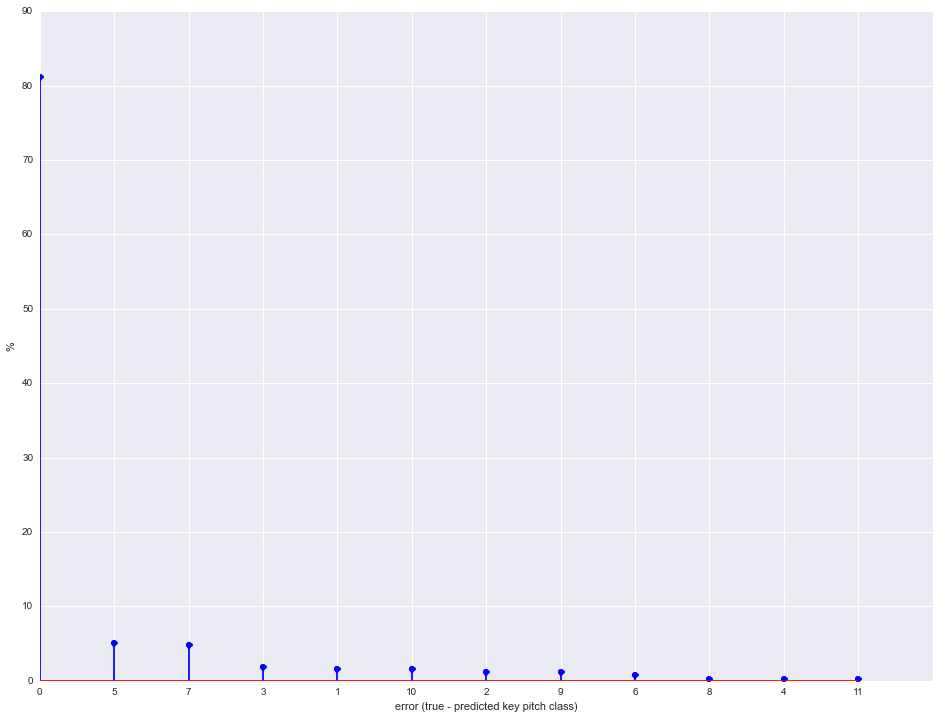

In [101]:
theano_accuracy_report(exp04.network)

In [106]:
exp04.save('data/beatles/models/chords_keys_synth_theano_04.model')

INFO:theanets.graph:data/beatles/models/chords_keys_synth_theano_04.model: saved model


I 2015-09-22 22:10:21 theanets.graph:470 data/beatles/models/chords_keys_synth_theano_04.model: saved model


We can see that neural network models are able to squeeze even more from the data. By training a few models using theano (up to to hidden layers with autoencoder pretraining and input dropout regularization) we were able to improve the accuracy by 10% points relative to the logistic regression (71% to 81%).

The error analysis still show that the models have mostly problems with discriminating keys close on the circle of fifths.

## Summary

We could see that by using features designed with a bit care and a few rather simple models we were able to get past 80% performance of classifying key from chord sequences. This is quite a nice result for a few evenings of work.

### Where to go from now?

- we could better analyze the input data which exhibited errors and looks if there is anything to improve
- we could try to tune the models more
- we could try RNN models trained directly on the sequences of chords for whole songs (no fixed-size window contexts)
- we could try to apply the models to new datasets (other bands or gengres) and look for the performace